In [11]:
import logging
import os
import sys
import tempfile
from glob import glob

import torch
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import monai
from monai.data import ArrayDataset, create_test_image_2d, decollate_batch
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandRotate90,
    RandSpatialCrop,
    ScaleIntensity,
    EnsureType,
)
from PIL import Image, ImageDraw

from monai.visualize import plot_2d_or_3d_image
import numpy as np
import matplotlib.pyplot as plt

from typing import Optional, Tuple
from monai.transforms.utils import rescale_array
from os import mkdir
from os.path import isdir



In [12]:
print(monai.__version__)

ROOT_EXP   = '/home/diffusion/Dropbox/Documents/CHUV/ASAP/FederatedLearning/fedem/'
EXPERIMENT = 'synthetic/' # 'synthetic', 'ISLES', 'BRATS'
ROOT_DATA  = 'data/'+EXPERIMENT

if( not isdir(ROOT_EXP+"/models/"+EXPERIMENT)):
    mkdir(ROOT_EXP+"/models/"+EXPERIMENT)
    
#At insel: /home/sebastian/experiments/fedem/data/'

0.8.0


In [13]:
monai.config.print_config()
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

MONAI version: 0.8.0
Numpy version: 1.20.3
Pytorch version: 1.10.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 714d00dffe6653e21260160666c4c201ab66511b

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.18.1
Pillow version: 8.3.1
Tensorboard version: 2.7.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.11.1
tqdm version: 4.62.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.8.0
pandas version: 1.3.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.11.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [14]:
train_dir = ROOT_DATA + 'train/'
val_dir   = ROOT_DATA + 'val/'
test_dir  = ROOT_DATA + 'test/'

# First Silo (SQUARES)

In [30]:
imagepaths_train  = sorted(glob(os.path.join(train_dir, "square*img*.png")))
segmpaths_train   = sorted(glob(os.path.join(train_dir, "square*seg*.png")))
print(len(imagepaths_train),len(segmpaths_train))

imagepaths_val  = sorted(glob(os.path.join(val_dir, "square*img*.png")))
segmpaths_val   = sorted(glob(os.path.join(val_dir, "square*seg*.png")))
print(len(imagepaths_val),len(segmpaths_val))

imagepaths_test  = sorted(glob(os.path.join(test_dir, "*img*.png")))
segmpaths_test   = sorted(glob(os.path.join(test_dir, "*seg*.png")))
print(len(imagepaths_test),len(segmpaths_test))

OUTPUT = ROOT_EXP + 'results_distributed_squares/'

if(not isdir(OUTPUT)):
    mkdir(OUTPUT)
    

25 25
5 5
20 20


In [31]:
imagepaths_train

['data/synthetic/train/square_img15.png',
 'data/synthetic/train/square_img16.png',
 'data/synthetic/train/square_img17.png',
 'data/synthetic/train/square_img18.png',
 'data/synthetic/train/square_img19.png',
 'data/synthetic/train/square_img20.png',
 'data/synthetic/train/square_img21.png',
 'data/synthetic/train/square_img22.png',
 'data/synthetic/train/square_img23.png',
 'data/synthetic/train/square_img24.png',
 'data/synthetic/train/square_img25.png',
 'data/synthetic/train/square_img26.png',
 'data/synthetic/train/square_img27.png',
 'data/synthetic/train/square_img28.png',
 'data/synthetic/train/square_img29.png',
 'data/synthetic/train/square_img30.png',
 'data/synthetic/train/square_img31.png',
 'data/synthetic/train/square_img32.png',
 'data/synthetic/train/square_img33.png',
 'data/synthetic/train/square_img34.png',
 'data/synthetic/train/square_img35.png',
 'data/synthetic/train/square_img36.png',
 'data/synthetic/train/square_img37.png',
 'data/synthetic/train/square_img3

In [32]:
# define transforms for image and segmentation
train_imtrans = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        ScaleIntensity(),
        RandSpatialCrop((96, 96), random_size=False),
        RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        EnsureType(),
    ]
)
train_segtrans = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        ScaleIntensity(),
        RandSpatialCrop((96, 96), random_size=False),
        RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        EnsureType(),
    ]
)

In [33]:
val_imtrans  = Compose([LoadImage(image_only=True), AddChannel(), ScaleIntensity(), EnsureType()])
val_segtrans = Compose([LoadImage(image_only=True), AddChannel(), ScaleIntensity(), EnsureType()])

# define array dataset, data loader
check_ds     =    ArrayDataset(imagepaths_train, train_imtrans, segmpaths_train, train_segtrans)
check_loader = DataLoader(check_ds, batch_size=10, num_workers=2, pin_memory=torch.cuda.is_available())
im, seg      =  monai.utils.misc.first(check_loader)
print(im.shape, seg.shape)

torch.Size([10, 1, 96, 96]) torch.Size([10, 1, 96, 96])


In [34]:
# create a training data loader
train_ds = ArrayDataset(imagepaths_train, train_imtrans, segmpaths_train, train_segtrans)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=8, pin_memory=torch.cuda.is_available()
                         )
# create a validation data loader
val_ds = ArrayDataset(imagepaths_val, val_imtrans, segmpaths_val, val_segtrans)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4, pin_memory=torch.cuda.is_available())

#create the test data loader
test_ds = ArrayDataset(imagepaths_test, val_imtrans, segmpaths_test, val_segtrans)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=torch.cuda.is_available())

dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
dice_metric_test = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)


post_trans = Compose([EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
# create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


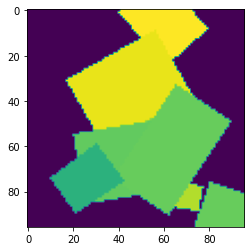

In [35]:
plt.imshow(train_ds[0][0][0].cpu())

Training for run 0
----------
epoch 1/10
1/6, train_loss: 0.5168
2/6, train_loss: 0.4510
3/6, train_loss: 0.4451
4/6, train_loss: 0.4532
5/6, train_loss: 0.4149
6/6, train_loss: 0.3606
7/6, train_loss: 0.3972
epoch 1 average loss: 0.4341
----------
epoch 2/10
1/6, train_loss: 0.3647
2/6, train_loss: 0.3653
3/6, train_loss: 0.4177
4/6, train_loss: 0.3689
5/6, train_loss: 0.3752
6/6, train_loss: 0.3717
7/6, train_loss: 0.3796
epoch 2 average loss: 0.3776
saved new best metric model
current epoch: 2 current mean dice: 0.8814 best mean dice: 0.8814 at epoch 2
----------
epoch 3/10
1/6, train_loss: 0.3442
2/6, train_loss: 0.4064
3/6, train_loss: 0.3403
4/6, train_loss: 0.3630
5/6, train_loss: 0.4133
6/6, train_loss: 0.3563
7/6, train_loss: 0.3154
epoch 3 average loss: 0.3627
----------
epoch 4/10
1/6, train_loss: 0.3525
2/6, train_loss: 0.3351
3/6, train_loss: 0.3857
4/6, train_loss: 0.3747
5/6, train_loss: 0.3143
6/6, train_loss: 0.3866
7/6, train_loss: 0.3392
epoch 4 average loss: 0.3554


1/6, train_loss: 0.2288
2/6, train_loss: 0.1806
3/6, train_loss: 0.2205
4/6, train_loss: 0.2534
5/6, train_loss: 0.1433
6/6, train_loss: 0.1698
7/6, train_loss: 0.1640
epoch 31 average loss: 0.1943
----------
epoch 32/10
1/6, train_loss: 0.2452
2/6, train_loss: 0.1431
3/6, train_loss: 0.2069
4/6, train_loss: 0.2252
5/6, train_loss: 0.1841
6/6, train_loss: 0.2083
7/6, train_loss: 0.1181
epoch 32 average loss: 0.1901
saved new best metric model
current epoch: 32 current mean dice: 0.9737 best mean dice: 0.9737 at epoch 32
----------
epoch 33/10
1/6, train_loss: 0.2058
2/6, train_loss: 0.1829
3/6, train_loss: 0.1266
4/6, train_loss: 0.1630
5/6, train_loss: 0.2463
6/6, train_loss: 0.1722
7/6, train_loss: 0.2147
epoch 33 average loss: 0.1874
----------
epoch 34/10
1/6, train_loss: 0.1933
2/6, train_loss: 0.2053
3/6, train_loss: 0.1757
4/6, train_loss: 0.1902
5/6, train_loss: 0.1701
6/6, train_loss: 0.1825
7/6, train_loss: 0.1616
epoch 34 average loss: 0.1827
saved new best metric model
curr

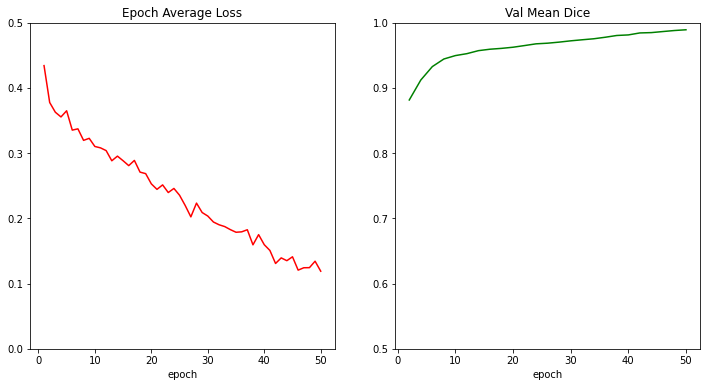

Dice in Test partition for run 00.996685802936554
Training for run 1
----------
epoch 1/10
1/6, train_loss: 0.5980
2/6, train_loss: 0.5439
3/6, train_loss: 0.5901
4/6, train_loss: 0.5463
5/6, train_loss: 0.5226
6/6, train_loss: 0.5212
7/6, train_loss: 0.5109
epoch 1 average loss: 0.5476
----------
epoch 2/10
1/6, train_loss: 0.5155
2/6, train_loss: 0.5171
3/6, train_loss: 0.5095
4/6, train_loss: 0.5357
5/6, train_loss: 0.4864
6/6, train_loss: 0.5048
7/6, train_loss: 0.4618
epoch 2 average loss: 0.5044
saved new best metric model
current epoch: 2 current mean dice: 0.8083 best mean dice: 0.8083 at epoch 2
----------
epoch 3/10
1/6, train_loss: 0.5137
2/6, train_loss: 0.4668
3/6, train_loss: 0.4978
4/6, train_loss: 0.5436
5/6, train_loss: 0.4835
6/6, train_loss: 0.4922
7/6, train_loss: 0.4210
epoch 3 average loss: 0.4884
----------
epoch 4/10
1/6, train_loss: 0.4625
2/6, train_loss: 0.4704
3/6, train_loss: 0.4871
4/6, train_loss: 0.4952
5/6, train_loss: 0.4853
6/6, train_loss: 0.4878
7/6

1/6, train_loss: 0.2137
2/6, train_loss: 0.2342
3/6, train_loss: 0.2042
4/6, train_loss: 0.2353
5/6, train_loss: 0.2506
6/6, train_loss: 0.2314
7/6, train_loss: 0.2437
epoch 31 average loss: 0.2304
----------
epoch 32/10
1/6, train_loss: 0.2454
2/6, train_loss: 0.2123
3/6, train_loss: 0.2025
4/6, train_loss: 0.2694
5/6, train_loss: 0.2044
6/6, train_loss: 0.2131
7/6, train_loss: 0.1736
epoch 32 average loss: 0.2173
saved new best metric model
current epoch: 32 current mean dice: 0.9926 best mean dice: 0.9926 at epoch 30
----------
epoch 33/10
1/6, train_loss: 0.2412
2/6, train_loss: 0.2204
3/6, train_loss: 0.2252
4/6, train_loss: 0.2115
5/6, train_loss: 0.2011
6/6, train_loss: 0.1741
7/6, train_loss: 0.1708
epoch 33 average loss: 0.2063
----------
epoch 34/10
1/6, train_loss: 0.1861
2/6, train_loss: 0.1966
3/6, train_loss: 0.2460
4/6, train_loss: 0.2163
5/6, train_loss: 0.1959
6/6, train_loss: 0.1871
7/6, train_loss: 0.1662
epoch 34 average loss: 0.1992
saved new best metric model
curr

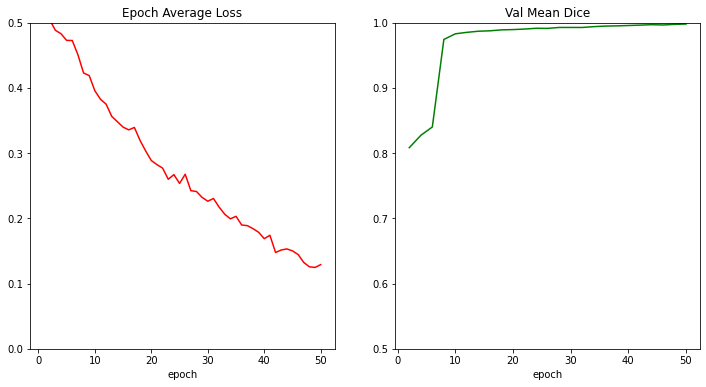

Dice in Test partition for run 10.9994232058525085
Training for run 2
----------
epoch 1/10
1/6, train_loss: 0.4621
2/6, train_loss: 0.4575
3/6, train_loss: 0.4512
4/6, train_loss: 0.3942
5/6, train_loss: 0.3957
6/6, train_loss: 0.3454
7/6, train_loss: 0.3629
epoch 1 average loss: 0.4098
----------
epoch 2/10
1/6, train_loss: 0.3321
2/6, train_loss: 0.3445
3/6, train_loss: 0.3881
4/6, train_loss: 0.3344
5/6, train_loss: 0.3496
6/6, train_loss: 0.3123
7/6, train_loss: 0.2981
epoch 2 average loss: 0.3370
saved new best metric model
current epoch: 2 current mean dice: 0.8838 best mean dice: 0.8838 at epoch 2
----------
epoch 3/10
1/6, train_loss: 0.3536
2/6, train_loss: 0.3355
3/6, train_loss: 0.2655
4/6, train_loss: 0.3163
5/6, train_loss: 0.4134
6/6, train_loss: 0.3625
7/6, train_loss: 0.2475
epoch 3 average loss: 0.3277
----------
epoch 4/10
1/6, train_loss: 0.4021
2/6, train_loss: 0.2817
3/6, train_loss: 0.3098
4/6, train_loss: 0.2999
5/6, train_loss: 0.2803
6/6, train_loss: 0.3241
7/

1/6, train_loss: 0.1526
2/6, train_loss: 0.1748
3/6, train_loss: 0.1654
4/6, train_loss: 0.2052
5/6, train_loss: 0.1649
6/6, train_loss: 0.1304
7/6, train_loss: 0.2460
epoch 31 average loss: 0.1770
----------
epoch 32/10
1/6, train_loss: 0.1562
2/6, train_loss: 0.2014
3/6, train_loss: 0.1258
4/6, train_loss: 0.1288
5/6, train_loss: 0.1841
6/6, train_loss: 0.1387
7/6, train_loss: 0.1129
epoch 32 average loss: 0.1497
saved new best metric model
current epoch: 32 current mean dice: 0.9807 best mean dice: 0.9807 at epoch 32
----------
epoch 33/10
1/6, train_loss: 0.1132
2/6, train_loss: 0.1432
3/6, train_loss: 0.1232
4/6, train_loss: 0.1875
5/6, train_loss: 0.1715
6/6, train_loss: 0.1802
7/6, train_loss: 0.2148
epoch 33 average loss: 0.1619
----------
epoch 34/10
1/6, train_loss: 0.1295
2/6, train_loss: 0.1623
3/6, train_loss: 0.1618
4/6, train_loss: 0.1867
5/6, train_loss: 0.1552
6/6, train_loss: 0.1660
7/6, train_loss: 0.0991
epoch 34 average loss: 0.1515
saved new best metric model
curr

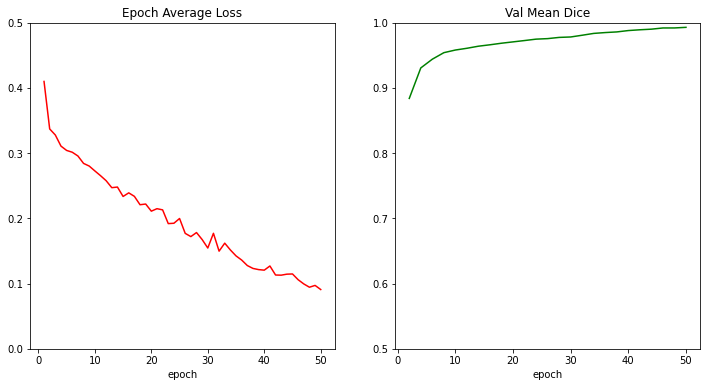

Dice in Test partition for run 20.9979985952377319
Training for run 3
----------
epoch 1/10
1/6, train_loss: 0.5451
2/6, train_loss: 0.5211
3/6, train_loss: 0.4848
4/6, train_loss: 0.4719
5/6, train_loss: 0.5129
6/6, train_loss: 0.4100
7/6, train_loss: 0.4018
epoch 1 average loss: 0.4782
----------
epoch 2/10
1/6, train_loss: 0.4059
2/6, train_loss: 0.4225
3/6, train_loss: 0.4009
4/6, train_loss: 0.4343
5/6, train_loss: 0.4697
6/6, train_loss: 0.3869
7/6, train_loss: 0.3658
epoch 2 average loss: 0.4123
saved new best metric model
current epoch: 2 current mean dice: 0.5892 best mean dice: 0.5892 at epoch 2
----------
epoch 3/10
1/6, train_loss: 0.4259
2/6, train_loss: 0.4138
3/6, train_loss: 0.4157
4/6, train_loss: 0.4210
5/6, train_loss: 0.3893
6/6, train_loss: 0.3886
7/6, train_loss: 0.3203
epoch 3 average loss: 0.3964
----------
epoch 4/10
1/6, train_loss: 0.3799
2/6, train_loss: 0.4033
3/6, train_loss: 0.3454
4/6, train_loss: 0.3909
5/6, train_loss: 0.4333
6/6, train_loss: 0.4105
7/

1/6, train_loss: 0.2580
2/6, train_loss: 0.1931
3/6, train_loss: 0.2153
4/6, train_loss: 0.2477
5/6, train_loss: 0.1913
6/6, train_loss: 0.2070
7/6, train_loss: 0.1632
epoch 31 average loss: 0.2108
----------
epoch 32/10
1/6, train_loss: 0.2528
2/6, train_loss: 0.2210
3/6, train_loss: 0.2235
4/6, train_loss: 0.1983
5/6, train_loss: 0.2291
6/6, train_loss: 0.2311
7/6, train_loss: 0.2082
epoch 32 average loss: 0.2235
saved new best metric model
current epoch: 32 current mean dice: 0.9789 best mean dice: 0.9789 at epoch 32
----------
epoch 33/10
1/6, train_loss: 0.2580
2/6, train_loss: 0.2018
3/6, train_loss: 0.2615
4/6, train_loss: 0.1717
5/6, train_loss: 0.2114
6/6, train_loss: 0.1668
7/6, train_loss: 0.1772
epoch 33 average loss: 0.2069
----------
epoch 34/10
1/6, train_loss: 0.2462
2/6, train_loss: 0.2043
3/6, train_loss: 0.2614
4/6, train_loss: 0.2569
5/6, train_loss: 0.1969
6/6, train_loss: 0.2020
7/6, train_loss: 0.1532
epoch 34 average loss: 0.2173
saved new best metric model
curr

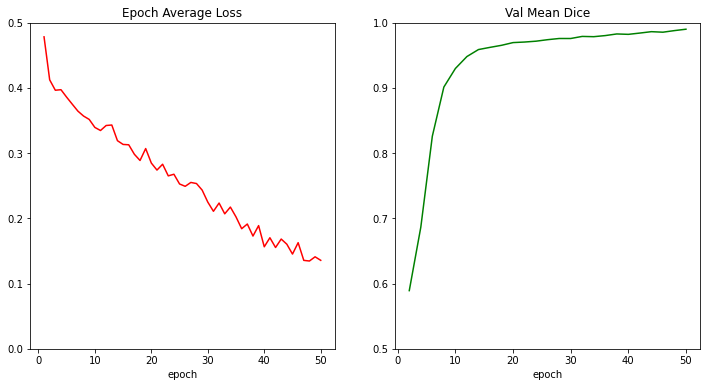

Dice in Test partition for run 30.9968260526657104
Training for run 4
----------
epoch 1/10
1/6, train_loss: 0.5812
2/6, train_loss: 0.5682
3/6, train_loss: 0.4813
4/6, train_loss: 0.4491
5/6, train_loss: 0.4807
6/6, train_loss: 0.4631
7/6, train_loss: 0.4320
epoch 1 average loss: 0.4936
----------
epoch 2/10
1/6, train_loss: 0.4767
2/6, train_loss: 0.4297
3/6, train_loss: 0.4667
4/6, train_loss: 0.4337
5/6, train_loss: 0.4683
6/6, train_loss: 0.4499
7/6, train_loss: 0.3991
epoch 2 average loss: 0.4463
saved new best metric model
current epoch: 2 current mean dice: 0.8727 best mean dice: 0.8727 at epoch 2
----------
epoch 3/10
1/6, train_loss: 0.4611
2/6, train_loss: 0.4176
3/6, train_loss: 0.4388
4/6, train_loss: 0.4419
5/6, train_loss: 0.4094
6/6, train_loss: 0.3964
7/6, train_loss: 0.4369
epoch 3 average loss: 0.4289
----------
epoch 4/10
1/6, train_loss: 0.4406
2/6, train_loss: 0.3981
3/6, train_loss: 0.4073
4/6, train_loss: 0.4550
5/6, train_loss: 0.4782
6/6, train_loss: 0.4440
7/

1/6, train_loss: 0.2560
2/6, train_loss: 0.2305
3/6, train_loss: 0.2538
4/6, train_loss: 0.2781
5/6, train_loss: 0.2009
6/6, train_loss: 0.2345
7/6, train_loss: 0.1941
epoch 31 average loss: 0.2354
----------
epoch 32/10
1/6, train_loss: 0.2217
2/6, train_loss: 0.1994
3/6, train_loss: 0.2142
4/6, train_loss: 0.2649
5/6, train_loss: 0.2448
6/6, train_loss: 0.2382
7/6, train_loss: 0.1524
epoch 32 average loss: 0.2194
saved new best metric model
current epoch: 32 current mean dice: 0.9871 best mean dice: 0.9871 at epoch 32
----------
epoch 33/10
1/6, train_loss: 0.2094
2/6, train_loss: 0.2337
3/6, train_loss: 0.2102
4/6, train_loss: 0.2130
5/6, train_loss: 0.2178
6/6, train_loss: 0.2280
7/6, train_loss: 0.1584
epoch 33 average loss: 0.2101
----------
epoch 34/10
1/6, train_loss: 0.1994
2/6, train_loss: 0.2597
3/6, train_loss: 0.2366
4/6, train_loss: 0.2325
5/6, train_loss: 0.2242
6/6, train_loss: 0.1730
7/6, train_loss: 0.1637
epoch 34 average loss: 0.2127
saved new best metric model
curr

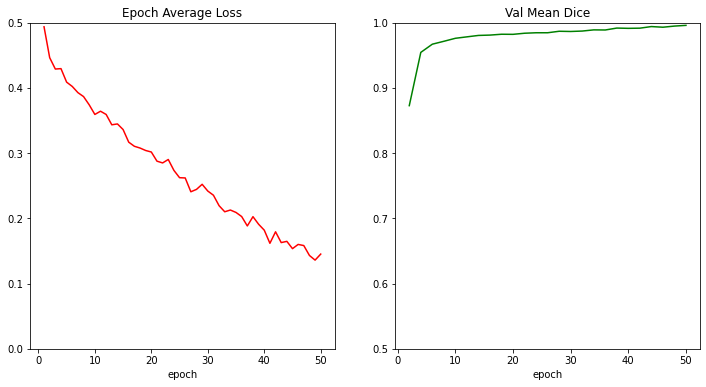

Dice in Test partition for run 40.9988557696342468
Training for run 5
----------
epoch 1/10
1/6, train_loss: 0.5534
2/6, train_loss: 0.5901
3/6, train_loss: 0.5376
4/6, train_loss: 0.5192
5/6, train_loss: 0.5366
6/6, train_loss: 0.5332
7/6, train_loss: 0.4590
epoch 1 average loss: 0.5327
----------
epoch 2/10
1/6, train_loss: 0.5470
2/6, train_loss: 0.4533
3/6, train_loss: 0.5064
4/6, train_loss: 0.5058
5/6, train_loss: 0.4887
6/6, train_loss: 0.4745
7/6, train_loss: 0.4613
epoch 2 average loss: 0.4910
saved new best metric model
current epoch: 2 current mean dice: 0.4441 best mean dice: 0.4441 at epoch 2
----------
epoch 3/10
1/6, train_loss: 0.4808
2/6, train_loss: 0.4983
3/6, train_loss: 0.4896
4/6, train_loss: 0.4733
5/6, train_loss: 0.5193
6/6, train_loss: 0.4900
7/6, train_loss: 0.3853
epoch 3 average loss: 0.4767
----------
epoch 4/10
1/6, train_loss: 0.4771
2/6, train_loss: 0.4552
3/6, train_loss: 0.4497
4/6, train_loss: 0.4726
5/6, train_loss: 0.4835
6/6, train_loss: 0.4681
7/

1/6, train_loss: 0.2643
2/6, train_loss: 0.2595
3/6, train_loss: 0.2652
4/6, train_loss: 0.2686
5/6, train_loss: 0.2890
6/6, train_loss: 0.2381
7/6, train_loss: 0.2937
epoch 31 average loss: 0.2684
----------
epoch 32/10
1/6, train_loss: 0.2452
2/6, train_loss: 0.2443
3/6, train_loss: 0.2329
4/6, train_loss: 0.2640
5/6, train_loss: 0.2392
6/6, train_loss: 0.2507
7/6, train_loss: 0.1739
epoch 32 average loss: 0.2358
saved new best metric model
current epoch: 32 current mean dice: 0.9799 best mean dice: 0.9800 at epoch 30
----------
epoch 33/10
1/6, train_loss: 0.2051
2/6, train_loss: 0.3168
3/6, train_loss: 0.2258
4/6, train_loss: 0.3188
5/6, train_loss: 0.2389
6/6, train_loss: 0.2253
7/6, train_loss: 0.2382
epoch 33 average loss: 0.2527
----------
epoch 34/10
1/6, train_loss: 0.2412
2/6, train_loss: 0.2598
3/6, train_loss: 0.2803
4/6, train_loss: 0.2251
5/6, train_loss: 0.2327
6/6, train_loss: 0.2226
7/6, train_loss: 0.3108
epoch 34 average loss: 0.2532
saved new best metric model
curr

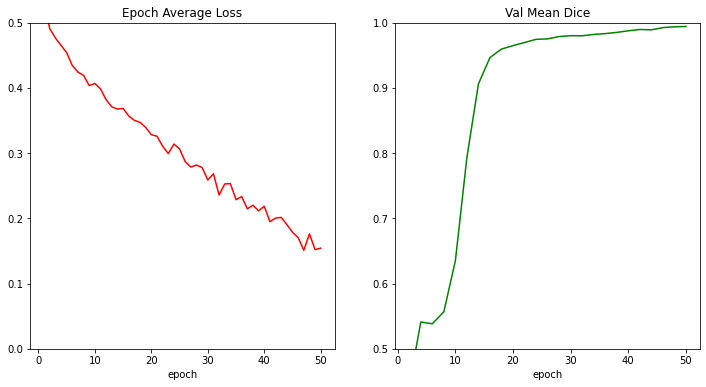

Dice in Test partition for run 50.9989209175109863
Training for run 6
----------
epoch 1/10
1/6, train_loss: 0.5965
2/6, train_loss: 0.5001
3/6, train_loss: 0.4310
4/6, train_loss: 0.3811
5/6, train_loss: 0.3572
6/6, train_loss: 0.4647
7/6, train_loss: 0.3079
epoch 1 average loss: 0.4341
----------
epoch 2/10
1/6, train_loss: 0.3203
2/6, train_loss: 0.3518
3/6, train_loss: 0.3238
4/6, train_loss: 0.3178
5/6, train_loss: 0.3954
6/6, train_loss: 0.2711
7/6, train_loss: 0.3878
epoch 2 average loss: 0.3383
saved new best metric model
current epoch: 2 current mean dice: 0.9149 best mean dice: 0.9149 at epoch 2
----------
epoch 3/10
1/6, train_loss: 0.3455
2/6, train_loss: 0.3058
3/6, train_loss: 0.2753
4/6, train_loss: 0.2623
5/6, train_loss: 0.4183
6/6, train_loss: 0.3258
7/6, train_loss: 0.3145
epoch 3 average loss: 0.3211
----------
epoch 4/10
1/6, train_loss: 0.3318
2/6, train_loss: 0.2874
3/6, train_loss: 0.3243
4/6, train_loss: 0.2888
5/6, train_loss: 0.3025
6/6, train_loss: 0.2637
7/

1/6, train_loss: 0.1340
2/6, train_loss: 0.1490
3/6, train_loss: 0.1463
4/6, train_loss: 0.1608
5/6, train_loss: 0.1380
6/6, train_loss: 0.1268
7/6, train_loss: 0.1571
epoch 31 average loss: 0.1446
----------
epoch 32/10
1/6, train_loss: 0.1677
2/6, train_loss: 0.1022
3/6, train_loss: 0.1895
4/6, train_loss: 0.1231
5/6, train_loss: 0.1715
6/6, train_loss: 0.1874
7/6, train_loss: 0.1278
epoch 32 average loss: 0.1527
saved new best metric model
current epoch: 32 current mean dice: 0.9796 best mean dice: 0.9796 at epoch 32
----------
epoch 33/10
1/6, train_loss: 0.1154
2/6, train_loss: 0.1939
3/6, train_loss: 0.1535
4/6, train_loss: 0.1085
5/6, train_loss: 0.1524
6/6, train_loss: 0.1316
7/6, train_loss: 0.0923
epoch 33 average loss: 0.1354
----------
epoch 34/10
1/6, train_loss: 0.1567
2/6, train_loss: 0.1476
3/6, train_loss: 0.1345
4/6, train_loss: 0.1269
5/6, train_loss: 0.1424
6/6, train_loss: 0.1215
7/6, train_loss: 0.0675
epoch 34 average loss: 0.1282
saved new best metric model
curr

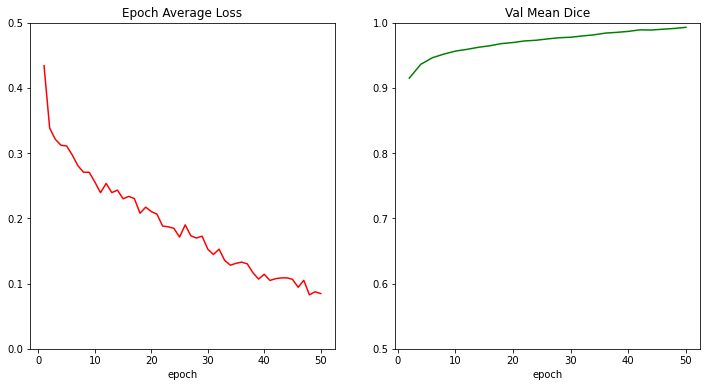

Dice in Test partition for run 60.9979454278945923
Training for run 7
----------
epoch 1/10
1/6, train_loss: 0.4700
2/6, train_loss: 0.4704
3/6, train_loss: 0.4060
4/6, train_loss: 0.3974
5/6, train_loss: 0.3924
6/6, train_loss: 0.4007
7/6, train_loss: 0.4337
epoch 1 average loss: 0.4244
----------
epoch 2/10
1/6, train_loss: 0.4000
2/6, train_loss: 0.3522
3/6, train_loss: 0.3612
4/6, train_loss: 0.3702
5/6, train_loss: 0.3495
6/6, train_loss: 0.3723
7/6, train_loss: 0.4378
epoch 2 average loss: 0.3776
saved new best metric model
current epoch: 2 current mean dice: 0.8778 best mean dice: 0.8778 at epoch 2
----------
epoch 3/10
1/6, train_loss: 0.3716
2/6, train_loss: 0.2987
3/6, train_loss: 0.3495
4/6, train_loss: 0.3446
5/6, train_loss: 0.3307
6/6, train_loss: 0.3173
7/6, train_loss: 0.3338
epoch 3 average loss: 0.3352
----------
epoch 4/10
1/6, train_loss: 0.3114
2/6, train_loss: 0.4012
3/6, train_loss: 0.3364
4/6, train_loss: 0.3527
5/6, train_loss: 0.3261
6/6, train_loss: 0.3474
7/

1/6, train_loss: 0.1671
2/6, train_loss: 0.2214
3/6, train_loss: 0.2203
4/6, train_loss: 0.1549
5/6, train_loss: 0.1651
6/6, train_loss: 0.1723
7/6, train_loss: 0.1898
epoch 31 average loss: 0.1844
----------
epoch 32/10
1/6, train_loss: 0.1516
2/6, train_loss: 0.1704
3/6, train_loss: 0.1891
4/6, train_loss: 0.1851
5/6, train_loss: 0.1445
6/6, train_loss: 0.2040
7/6, train_loss: 0.2666
epoch 32 average loss: 0.1873
saved new best metric model
current epoch: 32 current mean dice: 0.9768 best mean dice: 0.9768 at epoch 32
----------
epoch 33/10
1/6, train_loss: 0.1711
2/6, train_loss: 0.1415
3/6, train_loss: 0.1457
4/6, train_loss: 0.1167
5/6, train_loss: 0.2046
6/6, train_loss: 0.1688
7/6, train_loss: 0.2086
epoch 33 average loss: 0.1653
----------
epoch 34/10
1/6, train_loss: 0.2551
2/6, train_loss: 0.1608
3/6, train_loss: 0.1329
4/6, train_loss: 0.1871
5/6, train_loss: 0.1602
6/6, train_loss: 0.1496
7/6, train_loss: 0.1743
epoch 34 average loss: 0.1743
saved new best metric model
curr

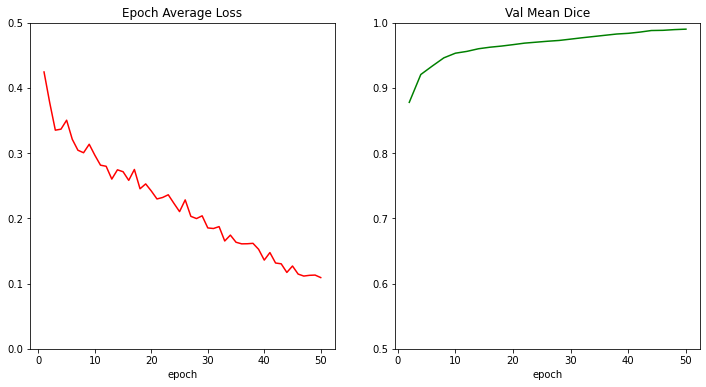

Dice in Test partition for run 70.9970711469650269
Training for run 8
----------
epoch 1/10
1/6, train_loss: 0.5294
2/6, train_loss: 0.4813
3/6, train_loss: 0.4925
4/6, train_loss: 0.4730
5/6, train_loss: 0.4376
6/6, train_loss: 0.3744
7/6, train_loss: 0.4140
epoch 1 average loss: 0.4575
----------
epoch 2/10
1/6, train_loss: 0.3714
2/6, train_loss: 0.3897
3/6, train_loss: 0.4218
4/6, train_loss: 0.4317
5/6, train_loss: 0.4282
6/6, train_loss: 0.3945
7/6, train_loss: 0.3988
epoch 2 average loss: 0.4052
saved new best metric model
current epoch: 2 current mean dice: 0.5235 best mean dice: 0.5235 at epoch 2
----------
epoch 3/10
1/6, train_loss: 0.4369
2/6, train_loss: 0.3771
3/6, train_loss: 0.3559
4/6, train_loss: 0.3759
5/6, train_loss: 0.4245
6/6, train_loss: 0.4195
7/6, train_loss: 0.3042
epoch 3 average loss: 0.3848
----------
epoch 4/10
1/6, train_loss: 0.4095
2/6, train_loss: 0.3761
3/6, train_loss: 0.4061
4/6, train_loss: 0.3450
5/6, train_loss: 0.3689
6/6, train_loss: 0.4134
7/

1/6, train_loss: 0.2553
2/6, train_loss: 0.2526
3/6, train_loss: 0.2165
4/6, train_loss: 0.1874
5/6, train_loss: 0.1869
6/6, train_loss: 0.2289
7/6, train_loss: 0.3155
epoch 31 average loss: 0.2347
----------
epoch 32/10
1/6, train_loss: 0.2021
2/6, train_loss: 0.2684
3/6, train_loss: 0.1855
4/6, train_loss: 0.1777
5/6, train_loss: 0.2044
6/6, train_loss: 0.2458
7/6, train_loss: 0.2544
epoch 32 average loss: 0.2198
saved new best metric model
current epoch: 32 current mean dice: 0.9695 best mean dice: 0.9695 at epoch 32
----------
epoch 33/10
1/6, train_loss: 0.2520
2/6, train_loss: 0.2397
3/6, train_loss: 0.1880
4/6, train_loss: 0.1884
5/6, train_loss: 0.1536
6/6, train_loss: 0.1811
7/6, train_loss: 0.3037
epoch 33 average loss: 0.2152
----------
epoch 34/10
1/6, train_loss: 0.1853
2/6, train_loss: 0.2781
3/6, train_loss: 0.1827
4/6, train_loss: 0.1878
5/6, train_loss: 0.2368
6/6, train_loss: 0.2175
7/6, train_loss: 0.1235
epoch 34 average loss: 0.2017
saved new best metric model
curr

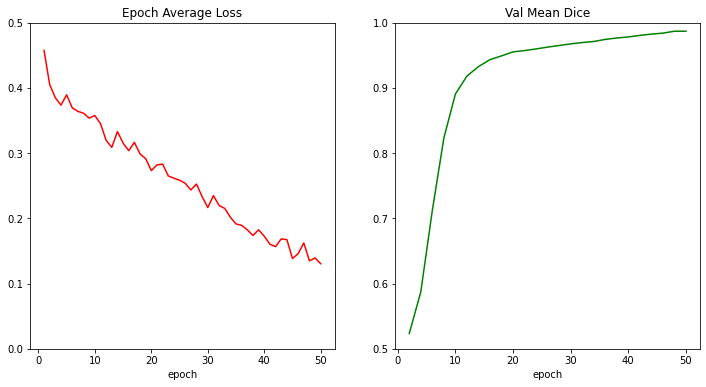

Dice in Test partition for run 80.9956918954849243
Training for run 9
----------
epoch 1/10
1/6, train_loss: 0.5258
2/6, train_loss: 0.4529
3/6, train_loss: 0.4360
4/6, train_loss: 0.4228
5/6, train_loss: 0.5030
6/6, train_loss: 0.4002
7/6, train_loss: 0.3582
epoch 1 average loss: 0.4427
----------
epoch 2/10
1/6, train_loss: 0.3885
2/6, train_loss: 0.4357
3/6, train_loss: 0.3778
4/6, train_loss: 0.3617
5/6, train_loss: 0.4092
6/6, train_loss: 0.3509
7/6, train_loss: 0.3818
epoch 2 average loss: 0.3865
saved new best metric model
current epoch: 2 current mean dice: 0.6121 best mean dice: 0.6121 at epoch 2
----------
epoch 3/10
1/6, train_loss: 0.3522
2/6, train_loss: 0.3645
3/6, train_loss: 0.3738
4/6, train_loss: 0.3205
5/6, train_loss: 0.4605
6/6, train_loss: 0.3483
7/6, train_loss: 0.3679
epoch 3 average loss: 0.3697
----------
epoch 4/10
1/6, train_loss: 0.3609
2/6, train_loss: 0.3300
3/6, train_loss: 0.3350
4/6, train_loss: 0.3085
5/6, train_loss: 0.4414
6/6, train_loss: 0.3468
7/

1/6, train_loss: 0.2534
2/6, train_loss: 0.2099
3/6, train_loss: 0.1814
4/6, train_loss: 0.2016
5/6, train_loss: 0.1537
6/6, train_loss: 0.1672
7/6, train_loss: 0.2733
epoch 31 average loss: 0.2058
----------
epoch 32/10
1/6, train_loss: 0.2364
2/6, train_loss: 0.1503
3/6, train_loss: 0.1943
4/6, train_loss: 0.2446
5/6, train_loss: 0.1920
6/6, train_loss: 0.1347
7/6, train_loss: 0.1786
epoch 32 average loss: 0.1901
saved new best metric model
current epoch: 32 current mean dice: 0.9745 best mean dice: 0.9745 at epoch 32
----------
epoch 33/10
1/6, train_loss: 0.1964
2/6, train_loss: 0.2041
3/6, train_loss: 0.1441
4/6, train_loss: 0.1637
5/6, train_loss: 0.1808
6/6, train_loss: 0.2005
7/6, train_loss: 0.2458
epoch 33 average loss: 0.1908
----------
epoch 34/10
1/6, train_loss: 0.2044
2/6, train_loss: 0.1768
3/6, train_loss: 0.2099
4/6, train_loss: 0.1568
5/6, train_loss: 0.1395
6/6, train_loss: 0.1879
7/6, train_loss: 0.1875
epoch 34 average loss: 0.1804
saved new best metric model
curr

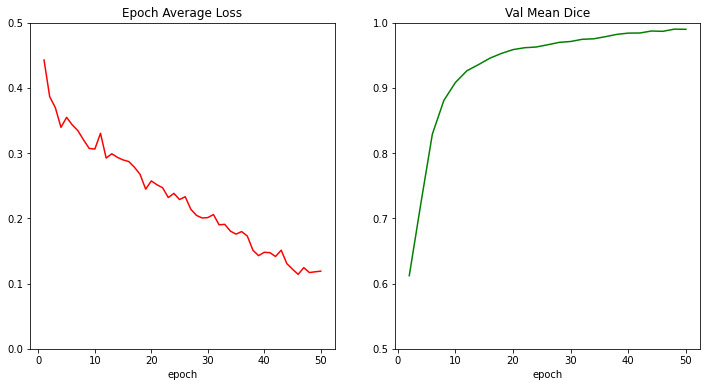

Dice in Test partition for run 90.9970281720161438


In [36]:
best_val_performances = []
test_performances = []
file_performances_test = open( OUTPUT+ 'performances_dice_'+EXPERIMENT.split('/')[0]+'.txt','w')
epocs = 50
runs = 10
for run_num in range(runs):
    print(f"Training for run {run_num}")
    model = monai.networks.nets.UNet(
        spatial_dims=2,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64, 128),
        strides=(2, 2, 2),
        num_res_units=2,
    ).to(device)

    loss_function = monai.losses.DiceLoss(sigmoid=True)
    optimizer     = torch.optim.Adam(model.parameters(), 1e-3)

    # start a typical PyTorch training
    val_interval = 2
    best_metric  = -1
    best_metric_epoch = -1
    
    epoch_loss_values  = list()
    metric_values      = list()
    metric_values_test = list()
    writer = SummaryWriter()
    
    for epoch in range(epocs):
        
        print("-" * 10)
        print(f"epoch {epoch + 1}/{10}")
        model.train()
        epoch_loss = 0
        step = 0
        
        for batch_data in train_loader:
            step += 1
            inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            epoch_len   = len(train_ds) // train_loader.batch_size
            
            print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
            writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
            
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
        if (epoch + 1) % val_interval == 0:
            model.eval()
            
            with torch.no_grad():
                val_images  = None
                val_labels  = None
                val_outputs = None
                
                for val_data in val_loader:
                    val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                    roi_size = (96, 96)
                    sw_batch_size = 4
                    val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                    val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                    # compute metric for current iteration
                    #print("========")
                    #print(val_outputs[0].shape,val_labels[0].shape)
                    dice_metric(y_pred=val_outputs, y=val_labels)
                    #print("========")

                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()
                metric_values.append(metric)
                
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    
                    torch.save(model.state_dict(),ROOT_EXP+"/models/"+EXPERIMENT+"run_" +str(run_num)+"_best_metric_model_segmentation2d_array.pth")
                   
                print("saved new best metric model")
                print(
                    "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                        epoch + 1, metric, best_metric, best_metric_epoch
                    )
                )
                writer.add_scalar("val_mean_dice", metric, epoch + 1)
                # plot the last model output as GIF image in TensorBoard with the corresponding image and label
                plot_2d_or_3d_image(val_images, epoch + 1, writer, index=0, tag="image")
                plot_2d_or_3d_image(val_labels, epoch + 1, writer, index=0, tag="label")
                plot_2d_or_3d_image(val_outputs, epoch + 1, writer, index=0, tag="output")
    
    best_val_performances.append(best_metric)
    
    
    plt.figure("train", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Epoch Average Loss")
    x = [i + 1 for i in range(len(epoch_loss_values))]
    y = epoch_loss_values
    plt.xlabel("epoch")
    plt.plot(x, y, color="red")
    plt.ylim([0.,0.5])
    plt.subplot(1, 2, 2)
    plt.title("Val Mean Dice")
    x = [val_interval * (i + 1) for i in range(len(metric_values))]
    y = metric_values
    plt.xlabel("epoch")
    plt.plot(x, y, color="green")
    plt.ylim([0.5,1])
    plt.savefig(OUTPUT+ f'trainin_dice_run_{run_num}_'+EXPERIMENT.split('/')[0]+'.jpg')
    plt.show()


    #Evaluation in the test partition
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        roi_size = (96, 96)
        sw_batch_size = 4
        test_outputs = sliding_window_inference(test_images, roi_size, sw_batch_size, model)
        test_outputs = [post_trans(i) for i in decollate_batch(test_outputs)]
        dice_metric_test(y_pred=test_outputs, y=test_labels)
    metric_test = dice_metric_test.aggregate().item()
    
    dice_metric_test.reset()
    test_performances.append(metric_test)
    print("Dice in Test partition for run " + str(run_num) + str(metric_test))
    file_performances_test.write(str(metric_test)+'\n')
    
    
    
file_performances_test.close()

In [39]:
metric_values

[0.6121284365653992,
 0.7222586870193481,
 0.8289119601249695,
 0.880728542804718,
 0.9082103967666626,
 0.9262768626213074,
 0.9355799555778503,
 0.9455634951591492,
 0.9528471231460571,
 0.9586493372917175,
 0.9615241885185242,
 0.9626300930976868,
 0.9660527110099792,
 0.9697548747062683,
 0.9711011052131653,
 0.9744560122489929,
 0.9752311706542969,
 0.978439211845398,
 0.9820108413696289,
 0.9839451909065247,
 0.9841073155403137,
 0.9871574640274048,
 0.9866737127304077,
 0.9900520443916321,
 0.9897705912590027]

In [40]:
test_performances

[0.996685802936554,
 0.9994232058525085,
 0.9979985952377319,
 0.9968260526657104,
 0.9988557696342468,
 0.9989209175109863,
 0.9979454278945923,
 0.9970711469650269,
 0.9956918954849243,
 0.9970281720161438]

In [42]:
best_val_performances

[0.9890633821487427,
 0.9978890419006348,
 0.9927974939346313,
 0.98992919921875,
 0.9958248138427734,
 0.9941099286079407,
 0.9928293228149414,
 0.9900134205818176,
 0.986855685710907,
 0.9900520443916321]

# Second Silo (Circles)

In [55]:
imagepaths_train  = sorted(glob(os.path.join(train_dir, "circle*img*.png")))
segmpaths_train   = sorted(glob(os.path.join(train_dir, "circle*seg*.png")))
print(len(imagepaths_train),len(segmpaths_train))

imagepaths_val  = sorted(glob(os.path.join(val_dir, "circle*img*.png")))
segmpaths_val   = sorted(glob(os.path.join(val_dir, "circle*seg*.png")))
print(len(imagepaths_val),len(segmpaths_val))

imagepaths_test  = sorted(glob(os.path.join(test_dir, "*img*.png")))
segmpaths_test   = sorted(glob(os.path.join(test_dir, "*seg*.png")))
print(len(imagepaths_test),len(segmpaths_test))

OUTPUT = ROOT_EXP + 'results_distributed_circles/'

if(not isdir(OUTPUT)):
    mkdir(OUTPUT)
    

65 65
5 5
20 20


In [56]:
# define transforms for image and segmentation
train_imtrans = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        ScaleIntensity(),
        RandSpatialCrop((96, 96), random_size=False),
        RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        EnsureType(),
    ]
)
train_segtrans = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        ScaleIntensity(),
        RandSpatialCrop((96, 96), random_size=False),
        RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        EnsureType(),
    ]
)

In [57]:
val_imtrans  = Compose([LoadImage(image_only=True), AddChannel(), ScaleIntensity(), EnsureType()])
val_segtrans = Compose([LoadImage(image_only=True), AddChannel(), ScaleIntensity(), EnsureType()])

# define array dataset, data loader
check_ds     =    ArrayDataset(imagepaths_train, train_imtrans, segmpaths_train, train_segtrans)
check_loader = DataLoader(check_ds, batch_size=10, num_workers=2, pin_memory=torch.cuda.is_available())
im, seg      =  monai.utils.misc.first(check_loader)
print(im.shape, seg.shape)

torch.Size([10, 1, 96, 96]) torch.Size([10, 1, 96, 96])


In [58]:
# create a training data loader
train_ds = ArrayDataset(imagepaths_train, train_imtrans, segmpaths_train, train_segtrans)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=8, pin_memory=torch.cuda.is_available()
                         )
# create a validation data loader
val_ds = ArrayDataset(imagepaths_val, val_imtrans, segmpaths_val, val_segtrans)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4, pin_memory=torch.cuda.is_available())

#create the test data loader
test_ds = ArrayDataset(imagepaths_test, val_imtrans, segmpaths_test, val_segtrans)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=torch.cuda.is_available())

dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
dice_metric_test = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)


post_trans = Compose([EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
# create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


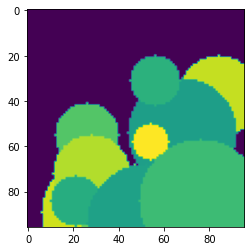

In [59]:
plt.imshow(train_ds[0][0][0].cpu())

Training for run 0
----------
epoch 1/10
1/16, train_loss: 0.3984
2/16, train_loss: 0.3993
3/16, train_loss: 0.4466
4/16, train_loss: 0.3708
5/16, train_loss: 0.3509
6/16, train_loss: 0.3872
7/16, train_loss: 0.3768
8/16, train_loss: 0.3923
9/16, train_loss: 0.3923
10/16, train_loss: 0.3860
11/16, train_loss: 0.3816
12/16, train_loss: 0.4045
13/16, train_loss: 0.4239
14/16, train_loss: 0.3883
15/16, train_loss: 0.3558
16/16, train_loss: 0.3516
17/16, train_loss: 0.3058
epoch 1 average loss: 0.3831
----------
epoch 2/10
1/16, train_loss: 0.3387
2/16, train_loss: 0.3490
3/16, train_loss: 0.3647
4/16, train_loss: 0.3419
5/16, train_loss: 0.3763
6/16, train_loss: 0.3721
7/16, train_loss: 0.3579
8/16, train_loss: 0.3816
9/16, train_loss: 0.3295
10/16, train_loss: 0.3611
11/16, train_loss: 0.3533
12/16, train_loss: 0.3603
13/16, train_loss: 0.3281
14/16, train_loss: 0.3526
15/16, train_loss: 0.3740
16/16, train_loss: 0.3531
17/16, train_loss: 0.3539
epoch 2 average loss: 0.3558
saved new bes

saved new best metric model
current epoch: 16 current mean dice: 0.9961 best mean dice: 0.9961 at epoch 16
----------
epoch 17/10
1/16, train_loss: 0.0963
2/16, train_loss: 0.1033
3/16, train_loss: 0.1108
4/16, train_loss: 0.1284
5/16, train_loss: 0.1139
6/16, train_loss: 0.1086
7/16, train_loss: 0.1345
8/16, train_loss: 0.1221
9/16, train_loss: 0.1418
10/16, train_loss: 0.1218
11/16, train_loss: 0.1185
12/16, train_loss: 0.1240
13/16, train_loss: 0.1161
14/16, train_loss: 0.1015
15/16, train_loss: 0.1008
16/16, train_loss: 0.1101
17/16, train_loss: 0.0933
epoch 17 average loss: 0.1145
----------
epoch 18/10
1/16, train_loss: 0.1041
2/16, train_loss: 0.1099
3/16, train_loss: 0.1363
4/16, train_loss: 0.1064
5/16, train_loss: 0.1306
6/16, train_loss: 0.1079
7/16, train_loss: 0.1323
8/16, train_loss: 0.1280
9/16, train_loss: 0.0894
10/16, train_loss: 0.0955
11/16, train_loss: 0.0967
12/16, train_loss: 0.0972
13/16, train_loss: 0.0925
14/16, train_loss: 0.0915
15/16, train_loss: 0.0904
16/

saved new best metric model
current epoch: 32 current mean dice: 0.9995 best mean dice: 0.9996 at epoch 30
----------
epoch 33/10
1/16, train_loss: 0.0437
2/16, train_loss: 0.0383
3/16, train_loss: 0.0432
4/16, train_loss: 0.0455
5/16, train_loss: 0.0368
6/16, train_loss: 0.0367
7/16, train_loss: 0.0308
8/16, train_loss: 0.0374
9/16, train_loss: 0.0519
10/16, train_loss: 0.0468
11/16, train_loss: 0.0370
12/16, train_loss: 0.0336
13/16, train_loss: 0.0378
14/16, train_loss: 0.0298
15/16, train_loss: 0.0314
16/16, train_loss: 0.0415
17/16, train_loss: 0.0289
epoch 33 average loss: 0.0383
----------
epoch 34/10
1/16, train_loss: 0.0351
2/16, train_loss: 0.0319
3/16, train_loss: 0.0502
4/16, train_loss: 0.0467
5/16, train_loss: 0.0322
6/16, train_loss: 0.0318
7/16, train_loss: 0.0300
8/16, train_loss: 0.0342
9/16, train_loss: 0.0311
10/16, train_loss: 0.0537
11/16, train_loss: 0.0291
12/16, train_loss: 0.0370
13/16, train_loss: 0.0353
14/16, train_loss: 0.0273
15/16, train_loss: 0.0451
16/

saved new best metric model
current epoch: 48 current mean dice: 0.9998 best mean dice: 0.9998 at epoch 44
----------
epoch 49/10
1/16, train_loss: 0.0253
2/16, train_loss: 0.0297
3/16, train_loss: 0.0279
4/16, train_loss: 0.0202
5/16, train_loss: 0.0157
6/16, train_loss: 0.0166
7/16, train_loss: 0.0305
8/16, train_loss: 0.0223
9/16, train_loss: 0.0263
10/16, train_loss: 0.0148
11/16, train_loss: 0.0196
12/16, train_loss: 0.0153
13/16, train_loss: 0.0163
14/16, train_loss: 0.0137
15/16, train_loss: 0.0191
16/16, train_loss: 0.0238
17/16, train_loss: 0.0138
epoch 49 average loss: 0.0206
----------
epoch 50/10
1/16, train_loss: 0.0217
2/16, train_loss: 0.0210
3/16, train_loss: 0.0191
4/16, train_loss: 0.0151
5/16, train_loss: 0.0244
6/16, train_loss: 0.0266
7/16, train_loss: 0.0184
8/16, train_loss: 0.0249
9/16, train_loss: 0.0203
10/16, train_loss: 0.0140
11/16, train_loss: 0.0213
12/16, train_loss: 0.0148
13/16, train_loss: 0.0155
14/16, train_loss: 0.0254
15/16, train_loss: 0.0209
16/

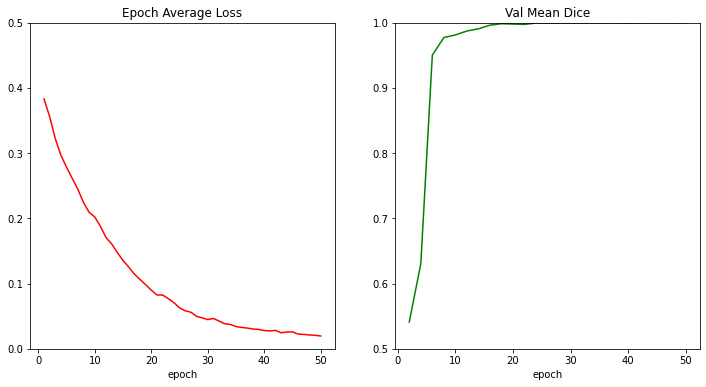

Dice in Test partition for run 00.9987756609916687
Training for run 1
----------
epoch 1/10
1/16, train_loss: 0.4538
2/16, train_loss: 0.4389
3/16, train_loss: 0.4116
4/16, train_loss: 0.4400
5/16, train_loss: 0.4532
6/16, train_loss: 0.4055
7/16, train_loss: 0.4259
8/16, train_loss: 0.4291
9/16, train_loss: 0.4266
10/16, train_loss: 0.3933
11/16, train_loss: 0.4293
12/16, train_loss: 0.4398
13/16, train_loss: 0.4015
14/16, train_loss: 0.3959
15/16, train_loss: 0.3943
16/16, train_loss: 0.4152
17/16, train_loss: 0.4569
epoch 1 average loss: 0.4242
----------
epoch 2/10
1/16, train_loss: 0.3917
2/16, train_loss: 0.4055
3/16, train_loss: 0.4023
4/16, train_loss: 0.3980
5/16, train_loss: 0.3884
6/16, train_loss: 0.3887
7/16, train_loss: 0.3952
8/16, train_loss: 0.4061
9/16, train_loss: 0.3725
10/16, train_loss: 0.3792
11/16, train_loss: 0.3867
12/16, train_loss: 0.4052
13/16, train_loss: 0.4043
14/16, train_loss: 0.3602
15/16, train_loss: 0.3633
16/16, train_loss: 0.3875
17/16, train_loss

saved new best metric model
current epoch: 16 current mean dice: 0.9981 best mean dice: 0.9983 at epoch 14
----------
epoch 17/10
1/16, train_loss: 0.1277
2/16, train_loss: 0.1340
3/16, train_loss: 0.1189
4/16, train_loss: 0.1260
5/16, train_loss: 0.1411
6/16, train_loss: 0.1267
7/16, train_loss: 0.1515
8/16, train_loss: 0.1385
9/16, train_loss: 0.1213
10/16, train_loss: 0.1372
11/16, train_loss: 0.1356
12/16, train_loss: 0.1169
13/16, train_loss: 0.1264
14/16, train_loss: 0.1196
15/16, train_loss: 0.1166
16/16, train_loss: 0.1445
17/16, train_loss: 0.1166
epoch 17 average loss: 0.1294
----------
epoch 18/10
1/16, train_loss: 0.1261
2/16, train_loss: 0.1222
3/16, train_loss: 0.1306
4/16, train_loss: 0.1117
5/16, train_loss: 0.1204
6/16, train_loss: 0.1224
7/16, train_loss: 0.1478
8/16, train_loss: 0.1120
9/16, train_loss: 0.1085
10/16, train_loss: 0.1257
11/16, train_loss: 0.1211
12/16, train_loss: 0.1082
13/16, train_loss: 0.1114
14/16, train_loss: 0.1148
15/16, train_loss: 0.1305
16/

saved new best metric model
current epoch: 32 current mean dice: 0.9995 best mean dice: 0.9995 at epoch 30
----------
epoch 33/10
1/16, train_loss: 0.0476
2/16, train_loss: 0.0443
3/16, train_loss: 0.0516
4/16, train_loss: 0.0425
5/16, train_loss: 0.0434
6/16, train_loss: 0.0552
7/16, train_loss: 0.0452
8/16, train_loss: 0.0592
9/16, train_loss: 0.0510
10/16, train_loss: 0.0594
11/16, train_loss: 0.0473
12/16, train_loss: 0.0463
13/16, train_loss: 0.0517
14/16, train_loss: 0.0408
15/16, train_loss: 0.0473
16/16, train_loss: 0.0595
17/16, train_loss: 0.0632
epoch 33 average loss: 0.0503
----------
epoch 34/10
1/16, train_loss: 0.0549
2/16, train_loss: 0.0558
3/16, train_loss: 0.0573
4/16, train_loss: 0.0549
5/16, train_loss: 0.0438
6/16, train_loss: 0.0411
7/16, train_loss: 0.0382
8/16, train_loss: 0.0424
9/16, train_loss: 0.0531
10/16, train_loss: 0.0439
11/16, train_loss: 0.0512
12/16, train_loss: 0.0381
13/16, train_loss: 0.0460
14/16, train_loss: 0.0457
15/16, train_loss: 0.0416
16/

saved new best metric model
current epoch: 48 current mean dice: 0.9999 best mean dice: 0.9999 at epoch 44
----------
epoch 49/10
1/16, train_loss: 0.0258
2/16, train_loss: 0.0225
3/16, train_loss: 0.0292
4/16, train_loss: 0.0251
5/16, train_loss: 0.0222
6/16, train_loss: 0.0301
7/16, train_loss: 0.0256
8/16, train_loss: 0.0372
9/16, train_loss: 0.0340
10/16, train_loss: 0.0249
11/16, train_loss: 0.0251
12/16, train_loss: 0.0282
13/16, train_loss: 0.0262
14/16, train_loss: 0.0197
15/16, train_loss: 0.0285
16/16, train_loss: 0.0302
17/16, train_loss: 0.0176
epoch 49 average loss: 0.0266
----------
epoch 50/10
1/16, train_loss: 0.0281
2/16, train_loss: 0.0252
3/16, train_loss: 0.0258
4/16, train_loss: 0.0254
5/16, train_loss: 0.0241
6/16, train_loss: 0.0241
7/16, train_loss: 0.0286
8/16, train_loss: 0.0303
9/16, train_loss: 0.0310
10/16, train_loss: 0.0257
11/16, train_loss: 0.0222
12/16, train_loss: 0.0242
13/16, train_loss: 0.0279
14/16, train_loss: 0.0221
15/16, train_loss: 0.0196
16/

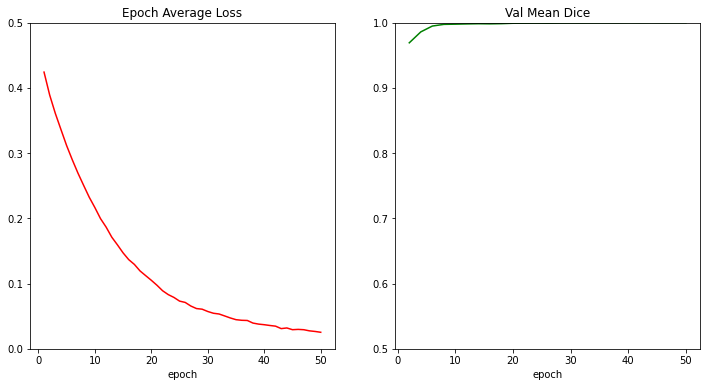

Dice in Test partition for run 10.9990277290344238
Training for run 2
----------
epoch 1/10
1/16, train_loss: 0.4275
2/16, train_loss: 0.3406
3/16, train_loss: 0.3313
4/16, train_loss: 0.2939
5/16, train_loss: 0.3018
6/16, train_loss: 0.2849
7/16, train_loss: 0.2845
8/16, train_loss: 0.2813
9/16, train_loss: 0.3014
10/16, train_loss: 0.2640
11/16, train_loss: 0.2770
12/16, train_loss: 0.2569
13/16, train_loss: 0.2659
14/16, train_loss: 0.2727
15/16, train_loss: 0.2758
16/16, train_loss: 0.2821
17/16, train_loss: 0.2343
epoch 1 average loss: 0.2927
----------
epoch 2/10
1/16, train_loss: 0.2911
2/16, train_loss: 0.2368
3/16, train_loss: 0.2492
4/16, train_loss: 0.2704
5/16, train_loss: 0.2215
6/16, train_loss: 0.2289
7/16, train_loss: 0.2499
8/16, train_loss: 0.2195
9/16, train_loss: 0.2463
10/16, train_loss: 0.2365
11/16, train_loss: 0.2509
12/16, train_loss: 0.2688
13/16, train_loss: 0.2627
14/16, train_loss: 0.2645
15/16, train_loss: 0.2311
16/16, train_loss: 0.2369
17/16, train_loss

saved new best metric model
current epoch: 16 current mean dice: 0.9969 best mean dice: 0.9969 at epoch 16
----------
epoch 17/10
1/16, train_loss: 0.0849
2/16, train_loss: 0.1161
3/16, train_loss: 0.0733
4/16, train_loss: 0.0761
5/16, train_loss: 0.0872
6/16, train_loss: 0.0800
7/16, train_loss: 0.0721
8/16, train_loss: 0.0878
9/16, train_loss: 0.0851
10/16, train_loss: 0.1004
11/16, train_loss: 0.0721
12/16, train_loss: 0.0739
13/16, train_loss: 0.0648
14/16, train_loss: 0.0698
15/16, train_loss: 0.0698
16/16, train_loss: 0.0838
17/16, train_loss: 0.0774
epoch 17 average loss: 0.0809
----------
epoch 18/10
1/16, train_loss: 0.1034
2/16, train_loss: 0.0807
3/16, train_loss: 0.0652
4/16, train_loss: 0.0998
5/16, train_loss: 0.0788
6/16, train_loss: 0.0811
7/16, train_loss: 0.0867
8/16, train_loss: 0.0652
9/16, train_loss: 0.0601
10/16, train_loss: 0.0859
11/16, train_loss: 0.0642
12/16, train_loss: 0.0822
13/16, train_loss: 0.0625
14/16, train_loss: 0.0902
15/16, train_loss: 0.0850
16/

saved new best metric model
current epoch: 32 current mean dice: 0.9996 best mean dice: 0.9997 at epoch 30
----------
epoch 33/10
1/16, train_loss: 0.0297
2/16, train_loss: 0.0228
3/16, train_loss: 0.0375
4/16, train_loss: 0.0247
5/16, train_loss: 0.0495
6/16, train_loss: 0.0333
7/16, train_loss: 0.0243
8/16, train_loss: 0.0264
9/16, train_loss: 0.0253
10/16, train_loss: 0.0214
11/16, train_loss: 0.0253
12/16, train_loss: 0.0213
13/16, train_loss: 0.0422
14/16, train_loss: 0.0273
15/16, train_loss: 0.0292
16/16, train_loss: 0.0245
17/16, train_loss: 0.0267
epoch 33 average loss: 0.0289
----------
epoch 34/10
1/16, train_loss: 0.0314
2/16, train_loss: 0.0261
3/16, train_loss: 0.0253
4/16, train_loss: 0.0392
5/16, train_loss: 0.0404
6/16, train_loss: 0.0325
7/16, train_loss: 0.0274
8/16, train_loss: 0.0214
9/16, train_loss: 0.0278
10/16, train_loss: 0.0289
11/16, train_loss: 0.0208
12/16, train_loss: 0.0332
13/16, train_loss: 0.0343
14/16, train_loss: 0.0294
15/16, train_loss: 0.0233
16/

saved new best metric model
current epoch: 48 current mean dice: 0.9999 best mean dice: 0.9999 at epoch 48
----------
epoch 49/10
1/16, train_loss: 0.0214
2/16, train_loss: 0.0143
3/16, train_loss: 0.0139
4/16, train_loss: 0.0102
5/16, train_loss: 0.0142
6/16, train_loss: 0.0202
7/16, train_loss: 0.0116
8/16, train_loss: 0.0139
9/16, train_loss: 0.0167
10/16, train_loss: 0.0130
11/16, train_loss: 0.0118
12/16, train_loss: 0.0221
13/16, train_loss: 0.0178
14/16, train_loss: 0.0172
15/16, train_loss: 0.0118
16/16, train_loss: 0.0137
17/16, train_loss: 0.0108
epoch 49 average loss: 0.0150
----------
epoch 50/10
1/16, train_loss: 0.0126
2/16, train_loss: 0.0203
3/16, train_loss: 0.0152
4/16, train_loss: 0.0132
5/16, train_loss: 0.0303
6/16, train_loss: 0.0110
7/16, train_loss: 0.0127
8/16, train_loss: 0.0192
9/16, train_loss: 0.0113
10/16, train_loss: 0.0104
11/16, train_loss: 0.0127
12/16, train_loss: 0.0175
13/16, train_loss: 0.0133
14/16, train_loss: 0.0113
15/16, train_loss: 0.0130
16/

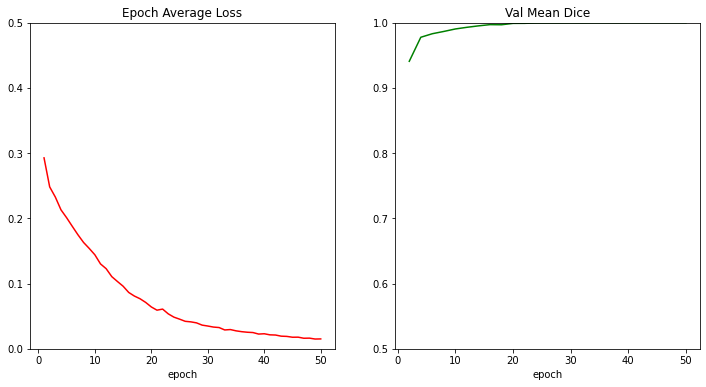

Dice in Test partition for run 20.998649001121521
Training for run 3
----------
epoch 1/10
1/16, train_loss: 0.3997
2/16, train_loss: 0.2943
3/16, train_loss: 0.2420
4/16, train_loss: 0.2391
5/16, train_loss: 0.2232
6/16, train_loss: 0.2286
7/16, train_loss: 0.2043
8/16, train_loss: 0.2000
9/16, train_loss: 0.2084
10/16, train_loss: 0.2010
11/16, train_loss: 0.1968
12/16, train_loss: 0.1859
13/16, train_loss: 0.1969
14/16, train_loss: 0.1988
15/16, train_loss: 0.1828
16/16, train_loss: 0.2010
17/16, train_loss: 0.1809
epoch 1 average loss: 0.2226
----------
epoch 2/10
1/16, train_loss: 0.1815
2/16, train_loss: 0.1832
3/16, train_loss: 0.1768
4/16, train_loss: 0.1950
5/16, train_loss: 0.1705
6/16, train_loss: 0.1851
7/16, train_loss: 0.1771
8/16, train_loss: 0.1712
9/16, train_loss: 0.1814
10/16, train_loss: 0.1780
11/16, train_loss: 0.1783
12/16, train_loss: 0.1845
13/16, train_loss: 0.1755
14/16, train_loss: 0.1673
15/16, train_loss: 0.1622
16/16, train_loss: 0.1690
17/16, train_loss:

saved new best metric model
current epoch: 16 current mean dice: 0.9981 best mean dice: 0.9981 at epoch 16
----------
epoch 17/10
1/16, train_loss: 0.0509
2/16, train_loss: 0.0544
3/16, train_loss: 0.0568
4/16, train_loss: 0.0549
5/16, train_loss: 0.0627
6/16, train_loss: 0.0462
7/16, train_loss: 0.0532
8/16, train_loss: 0.0575
9/16, train_loss: 0.0478
10/16, train_loss: 0.0547
11/16, train_loss: 0.0543
12/16, train_loss: 0.0649
13/16, train_loss: 0.0514
14/16, train_loss: 0.0536
15/16, train_loss: 0.0684
16/16, train_loss: 0.0497
17/16, train_loss: 0.0427
epoch 17 average loss: 0.0544
----------
epoch 18/10
1/16, train_loss: 0.0432
2/16, train_loss: 0.0488
3/16, train_loss: 0.0445
4/16, train_loss: 0.0483
5/16, train_loss: 0.0568
6/16, train_loss: 0.0415
7/16, train_loss: 0.0470
8/16, train_loss: 0.0480
9/16, train_loss: 0.0502
10/16, train_loss: 0.0558
11/16, train_loss: 0.0679
12/16, train_loss: 0.0431
13/16, train_loss: 0.0608
14/16, train_loss: 0.0485
15/16, train_loss: 0.0648
16/

saved new best metric model
current epoch: 32 current mean dice: 0.9995 best mean dice: 0.9995 at epoch 32
----------
epoch 33/10
1/16, train_loss: 0.0171
2/16, train_loss: 0.0180
3/16, train_loss: 0.0242
4/16, train_loss: 0.0263
5/16, train_loss: 0.0237
6/16, train_loss: 0.0300
7/16, train_loss: 0.0223
8/16, train_loss: 0.0208
9/16, train_loss: 0.0241
10/16, train_loss: 0.0194
11/16, train_loss: 0.0278
12/16, train_loss: 0.0178
13/16, train_loss: 0.0512
14/16, train_loss: 0.0255
15/16, train_loss: 0.0165
16/16, train_loss: 0.0247
17/16, train_loss: 0.0147
epoch 33 average loss: 0.0238
----------
epoch 34/10
1/16, train_loss: 0.0216
2/16, train_loss: 0.0211
3/16, train_loss: 0.0176
4/16, train_loss: 0.0213
5/16, train_loss: 0.0248
6/16, train_loss: 0.0344
7/16, train_loss: 0.0216
8/16, train_loss: 0.0225
9/16, train_loss: 0.0150
10/16, train_loss: 0.0216
11/16, train_loss: 0.0248
12/16, train_loss: 0.0199
13/16, train_loss: 0.0227
14/16, train_loss: 0.0211
15/16, train_loss: 0.0236
16/

saved new best metric model
current epoch: 48 current mean dice: 0.9999 best mean dice: 0.9999 at epoch 46
----------
epoch 49/10
1/16, train_loss: 0.0136
2/16, train_loss: 0.0222
3/16, train_loss: 0.0117
4/16, train_loss: 0.0179
5/16, train_loss: 0.0214
6/16, train_loss: 0.0260
7/16, train_loss: 0.0085
8/16, train_loss: 0.0141
9/16, train_loss: 0.0108
10/16, train_loss: 0.0153
11/16, train_loss: 0.0105
12/16, train_loss: 0.0094
13/16, train_loss: 0.0084
14/16, train_loss: 0.0116
15/16, train_loss: 0.0088
16/16, train_loss: 0.0115
17/16, train_loss: 0.0146
epoch 49 average loss: 0.0139
----------
epoch 50/10
1/16, train_loss: 0.0120
2/16, train_loss: 0.0103
3/16, train_loss: 0.0085
4/16, train_loss: 0.0156
5/16, train_loss: 0.0185
6/16, train_loss: 0.0115
7/16, train_loss: 0.0083
8/16, train_loss: 0.0122
9/16, train_loss: 0.0149
10/16, train_loss: 0.0108
11/16, train_loss: 0.0095
12/16, train_loss: 0.0074
13/16, train_loss: 0.0101
14/16, train_loss: 0.0118
15/16, train_loss: 0.0158
16/

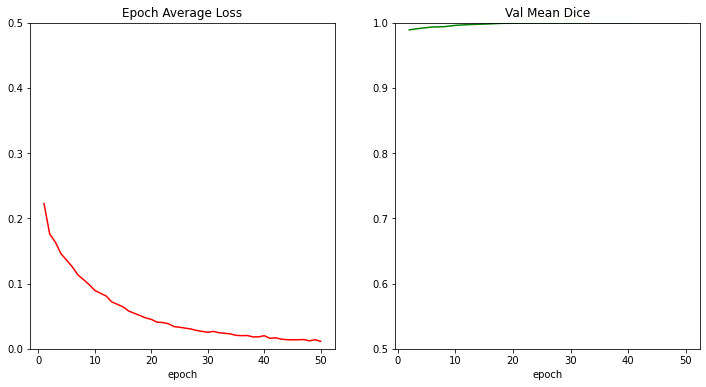

Dice in Test partition for run 30.9993247985839844
Training for run 4
----------
epoch 1/10
1/16, train_loss: 0.3900
2/16, train_loss: 0.3879
3/16, train_loss: 0.3643
4/16, train_loss: 0.3628
5/16, train_loss: 0.3784
6/16, train_loss: 0.3633
7/16, train_loss: 0.3772
8/16, train_loss: 0.3629
9/16, train_loss: 0.3589
10/16, train_loss: 0.3586
11/16, train_loss: 0.3593
12/16, train_loss: 0.3366
13/16, train_loss: 0.3528
14/16, train_loss: 0.3458
15/16, train_loss: 0.3230
16/16, train_loss: 0.3731
17/16, train_loss: 0.3316
epoch 1 average loss: 0.3604
----------
epoch 2/10
1/16, train_loss: 0.3260
2/16, train_loss: 0.3269
3/16, train_loss: 0.3284
4/16, train_loss: 0.3476
5/16, train_loss: 0.3253
6/16, train_loss: 0.3092
7/16, train_loss: 0.3415
8/16, train_loss: 0.3259
9/16, train_loss: 0.3323
10/16, train_loss: 0.3452
11/16, train_loss: 0.3290
12/16, train_loss: 0.3433
13/16, train_loss: 0.3082
14/16, train_loss: 0.3191
15/16, train_loss: 0.3087
16/16, train_loss: 0.3085
17/16, train_loss

saved new best metric model
current epoch: 16 current mean dice: 0.9978 best mean dice: 0.9978 at epoch 16
----------
epoch 17/10
1/16, train_loss: 0.1028
2/16, train_loss: 0.1150
3/16, train_loss: 0.0989
4/16, train_loss: 0.1218
5/16, train_loss: 0.1061
6/16, train_loss: 0.1201
7/16, train_loss: 0.1029
8/16, train_loss: 0.1000
9/16, train_loss: 0.1146
10/16, train_loss: 0.1018
11/16, train_loss: 0.1050
12/16, train_loss: 0.1264
13/16, train_loss: 0.1016
14/16, train_loss: 0.1127
15/16, train_loss: 0.1005
16/16, train_loss: 0.1062
17/16, train_loss: 0.0908
epoch 17 average loss: 0.1075
----------
epoch 18/10
1/16, train_loss: 0.1117
2/16, train_loss: 0.1029
3/16, train_loss: 0.1069
4/16, train_loss: 0.1049
5/16, train_loss: 0.0949
6/16, train_loss: 0.1008
7/16, train_loss: 0.0910
8/16, train_loss: 0.0972
9/16, train_loss: 0.0981
10/16, train_loss: 0.1081
11/16, train_loss: 0.0984
12/16, train_loss: 0.0934
13/16, train_loss: 0.1174
14/16, train_loss: 0.0868
15/16, train_loss: 0.0937
16/

saved new best metric model
current epoch: 32 current mean dice: 0.9997 best mean dice: 0.9997 at epoch 30
----------
epoch 33/10
1/16, train_loss: 0.0432
2/16, train_loss: 0.0554
3/16, train_loss: 0.0338
4/16, train_loss: 0.0476
5/16, train_loss: 0.0379
6/16, train_loss: 0.0562
7/16, train_loss: 0.0451
8/16, train_loss: 0.0337
9/16, train_loss: 0.0627
10/16, train_loss: 0.0349
11/16, train_loss: 0.0359
12/16, train_loss: 0.0342
13/16, train_loss: 0.0375
14/16, train_loss: 0.0394
15/16, train_loss: 0.0597
16/16, train_loss: 0.0347
17/16, train_loss: 0.0427
epoch 33 average loss: 0.0432
----------
epoch 34/10
1/16, train_loss: 0.0332
2/16, train_loss: 0.0417
3/16, train_loss: 0.0441
4/16, train_loss: 0.0325
5/16, train_loss: 0.0491
6/16, train_loss: 0.0441
7/16, train_loss: 0.0356
8/16, train_loss: 0.0500
9/16, train_loss: 0.0461
10/16, train_loss: 0.0400
11/16, train_loss: 0.0426
12/16, train_loss: 0.0459
13/16, train_loss: 0.0351
14/16, train_loss: 0.0359
15/16, train_loss: 0.0452
16/

saved new best metric model
current epoch: 48 current mean dice: 0.9998 best mean dice: 0.9998 at epoch 48
----------
epoch 49/10
1/16, train_loss: 0.0230
2/16, train_loss: 0.0232
3/16, train_loss: 0.0211
4/16, train_loss: 0.0303
5/16, train_loss: 0.0266
6/16, train_loss: 0.0203
7/16, train_loss: 0.0177
8/16, train_loss: 0.0172
9/16, train_loss: 0.0251
10/16, train_loss: 0.0267
11/16, train_loss: 0.0259
12/16, train_loss: 0.0201
13/16, train_loss: 0.0255
14/16, train_loss: 0.0184
15/16, train_loss: 0.0165
16/16, train_loss: 0.0216
17/16, train_loss: 0.0162
epoch 49 average loss: 0.0221
----------
epoch 50/10
1/16, train_loss: 0.0203
2/16, train_loss: 0.0198
3/16, train_loss: 0.0278
4/16, train_loss: 0.0183
5/16, train_loss: 0.0316
6/16, train_loss: 0.0282
7/16, train_loss: 0.0199
8/16, train_loss: 0.0203
9/16, train_loss: 0.0157
10/16, train_loss: 0.0243
11/16, train_loss: 0.0176
12/16, train_loss: 0.0215
13/16, train_loss: 0.0198
14/16, train_loss: 0.0186
15/16, train_loss: 0.0209
16/

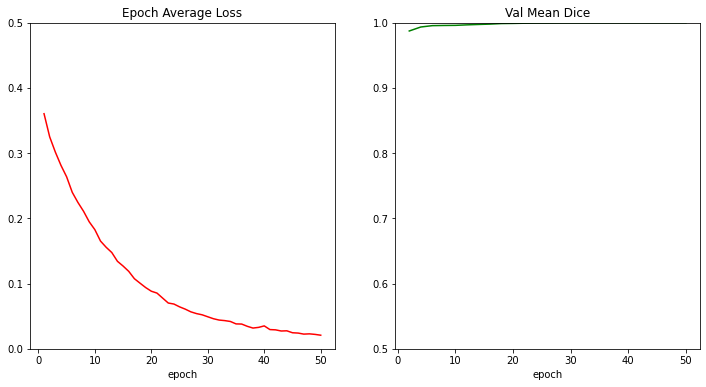

Dice in Test partition for run 40.999156653881073
Training for run 5
----------
epoch 1/10
1/16, train_loss: 0.4862
2/16, train_loss: 0.4201
3/16, train_loss: 0.3467
4/16, train_loss: 0.3806
5/16, train_loss: 0.3391
6/16, train_loss: 0.3322
7/16, train_loss: 0.3188
8/16, train_loss: 0.2999
9/16, train_loss: 0.3048
10/16, train_loss: 0.3032
11/16, train_loss: 0.3243
12/16, train_loss: 0.3067
13/16, train_loss: 0.2961
14/16, train_loss: 0.2931
15/16, train_loss: 0.2970
16/16, train_loss: 0.2912
17/16, train_loss: 0.2976
epoch 1 average loss: 0.3316
----------
epoch 2/10
1/16, train_loss: 0.2788
2/16, train_loss: 0.2890
3/16, train_loss: 0.3056
4/16, train_loss: 0.2697
5/16, train_loss: 0.2769
6/16, train_loss: 0.2654
7/16, train_loss: 0.2799
8/16, train_loss: 0.2892
9/16, train_loss: 0.2674
10/16, train_loss: 0.2692
11/16, train_loss: 0.2841
12/16, train_loss: 0.2739
13/16, train_loss: 0.2873
14/16, train_loss: 0.2673
15/16, train_loss: 0.2615
16/16, train_loss: 0.2647
17/16, train_loss:

saved new best metric model
current epoch: 16 current mean dice: 0.9980 best mean dice: 0.9980 at epoch 16
----------
epoch 17/10
1/16, train_loss: 0.0831
2/16, train_loss: 0.0874
3/16, train_loss: 0.0978
4/16, train_loss: 0.0951
5/16, train_loss: 0.0995
6/16, train_loss: 0.0869
7/16, train_loss: 0.0883
8/16, train_loss: 0.0864
9/16, train_loss: 0.0873
10/16, train_loss: 0.0762
11/16, train_loss: 0.0767
12/16, train_loss: 0.0847
13/16, train_loss: 0.0782
14/16, train_loss: 0.0968
15/16, train_loss: 0.0856
16/16, train_loss: 0.0924
17/16, train_loss: 0.0821
epoch 17 average loss: 0.0873
----------
epoch 18/10
1/16, train_loss: 0.0846
2/16, train_loss: 0.1207
3/16, train_loss: 0.0731
4/16, train_loss: 0.0875
5/16, train_loss: 0.0763
6/16, train_loss: 0.0746
7/16, train_loss: 0.0720
8/16, train_loss: 0.0803
9/16, train_loss: 0.0906
10/16, train_loss: 0.0696
11/16, train_loss: 0.0856
12/16, train_loss: 0.1033
13/16, train_loss: 0.1023
14/16, train_loss: 0.0772
15/16, train_loss: 0.0829
16/

saved new best metric model
current epoch: 32 current mean dice: 0.9995 best mean dice: 0.9995 at epoch 32
----------
epoch 33/10
1/16, train_loss: 0.0343
2/16, train_loss: 0.0303
3/16, train_loss: 0.0325
4/16, train_loss: 0.0547
5/16, train_loss: 0.0346
6/16, train_loss: 0.0329
7/16, train_loss: 0.0313
8/16, train_loss: 0.0410
9/16, train_loss: 0.0355
10/16, train_loss: 0.0439
11/16, train_loss: 0.0304
12/16, train_loss: 0.0290
13/16, train_loss: 0.0539
14/16, train_loss: 0.0332
15/16, train_loss: 0.0269
16/16, train_loss: 0.0356
17/16, train_loss: 0.0250
epoch 33 average loss: 0.0356
----------
epoch 34/10
1/16, train_loss: 0.0438
2/16, train_loss: 0.0295
3/16, train_loss: 0.0373
4/16, train_loss: 0.0289
5/16, train_loss: 0.0320
6/16, train_loss: 0.0344
7/16, train_loss: 0.0343
8/16, train_loss: 0.0330
9/16, train_loss: 0.0397
10/16, train_loss: 0.0359
11/16, train_loss: 0.0282
12/16, train_loss: 0.0278
13/16, train_loss: 0.0329
14/16, train_loss: 0.0375
15/16, train_loss: 0.0387
16/

saved new best metric model
current epoch: 48 current mean dice: 0.9997 best mean dice: 0.9997 at epoch 48
----------
epoch 49/10
1/16, train_loss: 0.0276
2/16, train_loss: 0.0193
3/16, train_loss: 0.0198
4/16, train_loss: 0.0160
5/16, train_loss: 0.0255
6/16, train_loss: 0.0300
7/16, train_loss: 0.0221
8/16, train_loss: 0.0186
9/16, train_loss: 0.0200
10/16, train_loss: 0.0223
11/16, train_loss: 0.0132
12/16, train_loss: 0.0273
13/16, train_loss: 0.0183
14/16, train_loss: 0.0221
15/16, train_loss: 0.0204
16/16, train_loss: 0.0170
17/16, train_loss: 0.0128
epoch 49 average loss: 0.0207
----------
epoch 50/10
1/16, train_loss: 0.0139
2/16, train_loss: 0.0175
3/16, train_loss: 0.0156
4/16, train_loss: 0.0139
5/16, train_loss: 0.0167
6/16, train_loss: 0.0170
7/16, train_loss: 0.0186
8/16, train_loss: 0.0182
9/16, train_loss: 0.0242
10/16, train_loss: 0.0133
11/16, train_loss: 0.0149
12/16, train_loss: 0.0145
13/16, train_loss: 0.0188
14/16, train_loss: 0.0204
15/16, train_loss: 0.0369
16/

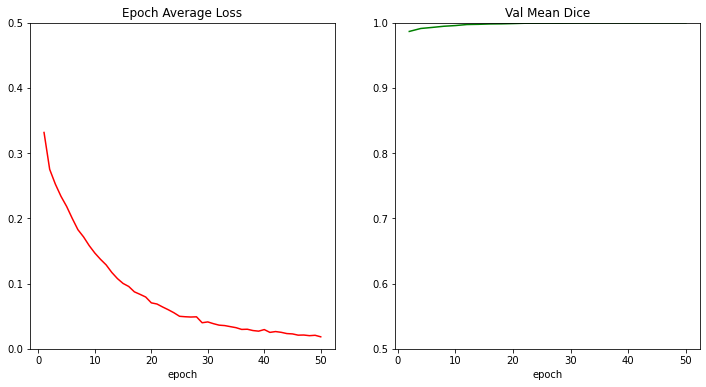

Dice in Test partition for run 50.9985172152519226
Training for run 6
----------
epoch 1/10
1/16, train_loss: 0.3832
2/16, train_loss: 0.3461
3/16, train_loss: 0.3243
4/16, train_loss: 0.3355
5/16, train_loss: 0.2947
6/16, train_loss: 0.2985
7/16, train_loss: 0.2806
8/16, train_loss: 0.2640
9/16, train_loss: 0.2724
10/16, train_loss: 0.2600
11/16, train_loss: 0.2584
12/16, train_loss: 0.2565
13/16, train_loss: 0.2534
14/16, train_loss: 0.2644
15/16, train_loss: 0.2513
16/16, train_loss: 0.2590
17/16, train_loss: 0.2704
epoch 1 average loss: 0.2866
----------
epoch 2/10
1/16, train_loss: 0.2548
2/16, train_loss: 0.2653
3/16, train_loss: 0.2636
4/16, train_loss: 0.2315
5/16, train_loss: 0.2499
6/16, train_loss: 0.2585
7/16, train_loss: 0.2359
8/16, train_loss: 0.2647
9/16, train_loss: 0.2553
10/16, train_loss: 0.2383
11/16, train_loss: 0.2636
12/16, train_loss: 0.2680
13/16, train_loss: 0.2558
14/16, train_loss: 0.2407
15/16, train_loss: 0.2246
16/16, train_loss: 0.2590
17/16, train_loss

saved new best metric model
current epoch: 16 current mean dice: 0.9973 best mean dice: 0.9973 at epoch 16
----------
epoch 17/10
1/16, train_loss: 0.0774
2/16, train_loss: 0.0826
3/16, train_loss: 0.0825
4/16, train_loss: 0.0743
5/16, train_loss: 0.0706
6/16, train_loss: 0.0841
7/16, train_loss: 0.0854
8/16, train_loss: 0.1031
9/16, train_loss: 0.0943
10/16, train_loss: 0.0968
11/16, train_loss: 0.0771
12/16, train_loss: 0.0785
13/16, train_loss: 0.0698
14/16, train_loss: 0.1031
15/16, train_loss: 0.0747
16/16, train_loss: 0.0859
17/16, train_loss: 0.0728
epoch 17 average loss: 0.0831
----------
epoch 18/10
1/16, train_loss: 0.0887
2/16, train_loss: 0.0885
3/16, train_loss: 0.0678
4/16, train_loss: 0.0724
5/16, train_loss: 0.0817
6/16, train_loss: 0.0675
7/16, train_loss: 0.0891
8/16, train_loss: 0.0718
9/16, train_loss: 0.0769
10/16, train_loss: 0.0821
11/16, train_loss: 0.0681
12/16, train_loss: 0.0762
13/16, train_loss: 0.0851
14/16, train_loss: 0.0682
15/16, train_loss: 0.0639
16/

saved new best metric model
current epoch: 32 current mean dice: 0.9996 best mean dice: 0.9996 at epoch 30
----------
epoch 33/10
1/16, train_loss: 0.0335
2/16, train_loss: 0.0358
3/16, train_loss: 0.0256
4/16, train_loss: 0.0377
5/16, train_loss: 0.0253
6/16, train_loss: 0.0275
7/16, train_loss: 0.0324
8/16, train_loss: 0.0280
9/16, train_loss: 0.0271
10/16, train_loss: 0.0357
11/16, train_loss: 0.0367
12/16, train_loss: 0.0230
13/16, train_loss: 0.0256
14/16, train_loss: 0.0341
15/16, train_loss: 0.0255
16/16, train_loss: 0.0336
17/16, train_loss: 0.0241
epoch 33 average loss: 0.0301
----------
epoch 34/10
1/16, train_loss: 0.0255
2/16, train_loss: 0.0360
3/16, train_loss: 0.0318
4/16, train_loss: 0.0231
5/16, train_loss: 0.0229
6/16, train_loss: 0.0421
7/16, train_loss: 0.0311
8/16, train_loss: 0.0263
9/16, train_loss: 0.0254
10/16, train_loss: 0.0221
11/16, train_loss: 0.0300
12/16, train_loss: 0.0284
13/16, train_loss: 0.0345
14/16, train_loss: 0.0265
15/16, train_loss: 0.0355
16/

saved new best metric model
current epoch: 48 current mean dice: 0.9998 best mean dice: 0.9999 at epoch 46
----------
epoch 49/10
1/16, train_loss: 0.0133
2/16, train_loss: 0.0150
3/16, train_loss: 0.0221
4/16, train_loss: 0.0130
5/16, train_loss: 0.0144
6/16, train_loss: 0.0172
7/16, train_loss: 0.0168
8/16, train_loss: 0.0128
9/16, train_loss: 0.0111
10/16, train_loss: 0.0202
11/16, train_loss: 0.0130
12/16, train_loss: 0.0143
13/16, train_loss: 0.0163
14/16, train_loss: 0.0128
15/16, train_loss: 0.0192
16/16, train_loss: 0.0223
17/16, train_loss: 0.0110
epoch 49 average loss: 0.0156
----------
epoch 50/10
1/16, train_loss: 0.0163
2/16, train_loss: 0.0122
3/16, train_loss: 0.0123
4/16, train_loss: 0.0136
5/16, train_loss: 0.0147
6/16, train_loss: 0.0137
7/16, train_loss: 0.0269
8/16, train_loss: 0.0225
9/16, train_loss: 0.0159
10/16, train_loss: 0.0160
11/16, train_loss: 0.0148
12/16, train_loss: 0.0155
13/16, train_loss: 0.0190
14/16, train_loss: 0.0133
15/16, train_loss: 0.0163
16/

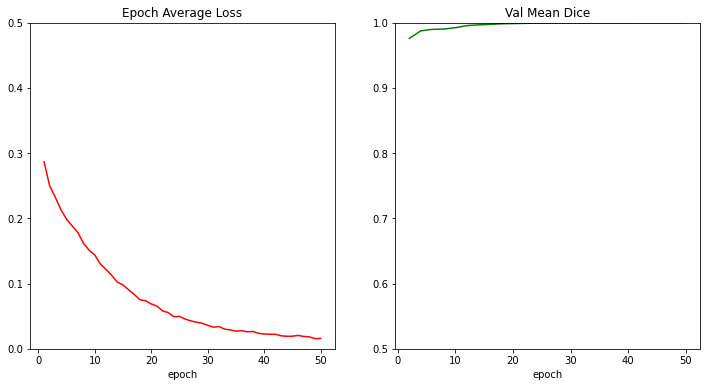

Dice in Test partition for run 60.9993299245834351
Training for run 7
----------
epoch 1/10
1/16, train_loss: 0.5342
2/16, train_loss: 0.4286
3/16, train_loss: 0.3690
4/16, train_loss: 0.3232
5/16, train_loss: 0.3118
6/16, train_loss: 0.2896
7/16, train_loss: 0.2845
8/16, train_loss: 0.3102
9/16, train_loss: 0.2824
10/16, train_loss: 0.2748
11/16, train_loss: 0.2711
12/16, train_loss: 0.2657
13/16, train_loss: 0.2601
14/16, train_loss: 0.2533
15/16, train_loss: 0.2596
16/16, train_loss: 0.2458
17/16, train_loss: 0.2410
epoch 1 average loss: 0.3062
----------
epoch 2/10
1/16, train_loss: 0.2534
2/16, train_loss: 0.2608
3/16, train_loss: 0.2354
4/16, train_loss: 0.2362
5/16, train_loss: 0.2382
6/16, train_loss: 0.2315
7/16, train_loss: 0.2416
8/16, train_loss: 0.2286
9/16, train_loss: 0.2296
10/16, train_loss: 0.2373
11/16, train_loss: 0.2242
12/16, train_loss: 0.2247
13/16, train_loss: 0.2383
14/16, train_loss: 0.2354
15/16, train_loss: 0.2184
16/16, train_loss: 0.2300
17/16, train_loss

saved new best metric model
current epoch: 16 current mean dice: 0.9984 best mean dice: 0.9984 at epoch 16
----------
epoch 17/10
1/16, train_loss: 0.0690
2/16, train_loss: 0.0732
3/16, train_loss: 0.0786
4/16, train_loss: 0.0788
5/16, train_loss: 0.0765
6/16, train_loss: 0.0691
7/16, train_loss: 0.0750
8/16, train_loss: 0.0833
9/16, train_loss: 0.0846
10/16, train_loss: 0.0678
11/16, train_loss: 0.0607
12/16, train_loss: 0.0711
13/16, train_loss: 0.0712
14/16, train_loss: 0.0682
15/16, train_loss: 0.0823
16/16, train_loss: 0.0703
17/16, train_loss: 0.0682
epoch 17 average loss: 0.0734
----------
epoch 18/10
1/16, train_loss: 0.0769
2/16, train_loss: 0.0777
3/16, train_loss: 0.0694
4/16, train_loss: 0.0647
5/16, train_loss: 0.0602
6/16, train_loss: 0.0623
7/16, train_loss: 0.0606
8/16, train_loss: 0.0729
9/16, train_loss: 0.0695
10/16, train_loss: 0.0795
11/16, train_loss: 0.0664
12/16, train_loss: 0.0685
13/16, train_loss: 0.0706
14/16, train_loss: 0.0560
15/16, train_loss: 0.0609
16/

epoch 32 average loss: 0.0310
saved new best metric model
current epoch: 32 current mean dice: 0.9995 best mean dice: 0.9995 at epoch 32
----------
epoch 33/10
1/16, train_loss: 0.0420
2/16, train_loss: 0.0282
3/16, train_loss: 0.0344
4/16, train_loss: 0.0314
5/16, train_loss: 0.0239
6/16, train_loss: 0.0313
7/16, train_loss: 0.0292
8/16, train_loss: 0.0297
9/16, train_loss: 0.0272
10/16, train_loss: 0.0258
11/16, train_loss: 0.0254
12/16, train_loss: 0.0336
13/16, train_loss: 0.0358
14/16, train_loss: 0.0243
15/16, train_loss: 0.0242
16/16, train_loss: 0.0222
17/16, train_loss: 0.0548
epoch 33 average loss: 0.0308
----------
epoch 34/10
1/16, train_loss: 0.0289
2/16, train_loss: 0.0233
3/16, train_loss: 0.0453
4/16, train_loss: 0.0328
5/16, train_loss: 0.0408
6/16, train_loss: 0.0350
7/16, train_loss: 0.0295
8/16, train_loss: 0.0231
9/16, train_loss: 0.0213
10/16, train_loss: 0.0312
11/16, train_loss: 0.0215
12/16, train_loss: 0.0369
13/16, train_loss: 0.0244
14/16, train_loss: 0.0256

1/16, train_loss: 0.0158
2/16, train_loss: 0.0167
3/16, train_loss: 0.0150
4/16, train_loss: 0.0184
5/16, train_loss: 0.0176
6/16, train_loss: 0.0215
7/16, train_loss: 0.0268
8/16, train_loss: 0.0204
9/16, train_loss: 0.0160
10/16, train_loss: 0.0155
11/16, train_loss: 0.0125
12/16, train_loss: 0.0140
13/16, train_loss: 0.0165
14/16, train_loss: 0.0145
15/16, train_loss: 0.0162
16/16, train_loss: 0.0136
17/16, train_loss: 0.0148
epoch 48 average loss: 0.0168
saved new best metric model
current epoch: 48 current mean dice: 0.9998 best mean dice: 0.9998 at epoch 48
----------
epoch 49/10
1/16, train_loss: 0.0151
2/16, train_loss: 0.0164
3/16, train_loss: 0.0193
4/16, train_loss: 0.0161
5/16, train_loss: 0.0195
6/16, train_loss: 0.0191
7/16, train_loss: 0.0183
8/16, train_loss: 0.0139
9/16, train_loss: 0.0135
10/16, train_loss: 0.0186
11/16, train_loss: 0.0146
12/16, train_loss: 0.0213
13/16, train_loss: 0.0132
14/16, train_loss: 0.0213
15/16, train_loss: 0.0183
16/16, train_loss: 0.0206


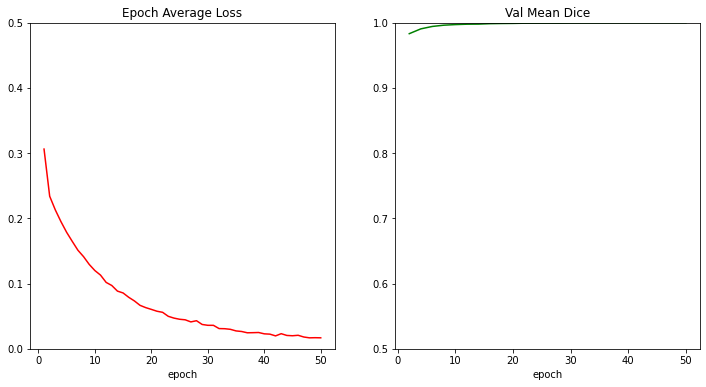

Dice in Test partition for run 70.9985048174858093
Training for run 8
----------
epoch 1/10
1/16, train_loss: 0.3848
2/16, train_loss: 0.3125
3/16, train_loss: 0.3086
4/16, train_loss: 0.2787
5/16, train_loss: 0.2707
6/16, train_loss: 0.2515
7/16, train_loss: 0.2663
8/16, train_loss: 0.2491
9/16, train_loss: 0.2425
10/16, train_loss: 0.2420
11/16, train_loss: 0.2614
12/16, train_loss: 0.2640
13/16, train_loss: 0.2414
14/16, train_loss: 0.2293
15/16, train_loss: 0.2399
16/16, train_loss: 0.2295
17/16, train_loss: 0.2334
epoch 1 average loss: 0.2650
----------
epoch 2/10
1/16, train_loss: 0.2251
2/16, train_loss: 0.2183
3/16, train_loss: 0.2384
4/16, train_loss: 0.2271
5/16, train_loss: 0.2240
6/16, train_loss: 0.2416
7/16, train_loss: 0.2313
8/16, train_loss: 0.2210
9/16, train_loss: 0.2341
10/16, train_loss: 0.2255
11/16, train_loss: 0.2298
12/16, train_loss: 0.2437
13/16, train_loss: 0.2189
14/16, train_loss: 0.2134
15/16, train_loss: 0.2186
16/16, train_loss: 0.2042
17/16, train_loss

epoch 16 average loss: 0.0773
saved new best metric model
current epoch: 16 current mean dice: 0.9973 best mean dice: 0.9973 at epoch 16
----------
epoch 17/10
1/16, train_loss: 0.0746
2/16, train_loss: 0.0667
3/16, train_loss: 0.0675
4/16, train_loss: 0.1009
5/16, train_loss: 0.0642
6/16, train_loss: 0.0768
7/16, train_loss: 0.0929
8/16, train_loss: 0.0622
9/16, train_loss: 0.0791
10/16, train_loss: 0.0683
11/16, train_loss: 0.0659
12/16, train_loss: 0.0689
13/16, train_loss: 0.0629
14/16, train_loss: 0.0717
15/16, train_loss: 0.0610
16/16, train_loss: 0.0723
17/16, train_loss: 0.0750
epoch 17 average loss: 0.0724
----------
epoch 18/10
1/16, train_loss: 0.0615
2/16, train_loss: 0.0604
3/16, train_loss: 0.0884
4/16, train_loss: 0.0639
5/16, train_loss: 0.0710
6/16, train_loss: 0.0590
7/16, train_loss: 0.0590
8/16, train_loss: 0.0758
9/16, train_loss: 0.0579
10/16, train_loss: 0.0574
11/16, train_loss: 0.0819
12/16, train_loss: 0.0811
13/16, train_loss: 0.0777
14/16, train_loss: 0.0542

1/16, train_loss: 0.0298
2/16, train_loss: 0.0382
3/16, train_loss: 0.0404
4/16, train_loss: 0.0349
5/16, train_loss: 0.0256
6/16, train_loss: 0.0235
7/16, train_loss: 0.0235
8/16, train_loss: 0.0253
9/16, train_loss: 0.0492
10/16, train_loss: 0.0260
11/16, train_loss: 0.0262
12/16, train_loss: 0.0341
13/16, train_loss: 0.0380
14/16, train_loss: 0.0282
15/16, train_loss: 0.0276
16/16, train_loss: 0.0339
17/16, train_loss: 0.0348
epoch 32 average loss: 0.0317
saved new best metric model
current epoch: 32 current mean dice: 0.9995 best mean dice: 0.9995 at epoch 32
----------
epoch 33/10
1/16, train_loss: 0.0252
2/16, train_loss: 0.0243
3/16, train_loss: 0.0274
4/16, train_loss: 0.0331
5/16, train_loss: 0.0304
6/16, train_loss: 0.0300
7/16, train_loss: 0.0288
8/16, train_loss: 0.0257
9/16, train_loss: 0.0377
10/16, train_loss: 0.0247
11/16, train_loss: 0.0300
12/16, train_loss: 0.0335
13/16, train_loss: 0.0271
14/16, train_loss: 0.0292
15/16, train_loss: 0.0275
16/16, train_loss: 0.0319


1/16, train_loss: 0.0139
2/16, train_loss: 0.0136
3/16, train_loss: 0.0254
4/16, train_loss: 0.0253
5/16, train_loss: 0.0224
6/16, train_loss: 0.0174
7/16, train_loss: 0.0175
8/16, train_loss: 0.0162
9/16, train_loss: 0.0145
10/16, train_loss: 0.0140
11/16, train_loss: 0.0124
12/16, train_loss: 0.0143
13/16, train_loss: 0.0122
14/16, train_loss: 0.0164
15/16, train_loss: 0.0125
16/16, train_loss: 0.0119
17/16, train_loss: 0.0401
epoch 48 average loss: 0.0176
saved new best metric model
current epoch: 48 current mean dice: 0.9998 best mean dice: 0.9998 at epoch 44
----------
epoch 49/10
1/16, train_loss: 0.0207
2/16, train_loss: 0.0143
3/16, train_loss: 0.0146
4/16, train_loss: 0.0137
5/16, train_loss: 0.0145
6/16, train_loss: 0.0349
7/16, train_loss: 0.0132
8/16, train_loss: 0.0138
9/16, train_loss: 0.0111
10/16, train_loss: 0.0169
11/16, train_loss: 0.0271
12/16, train_loss: 0.0132
13/16, train_loss: 0.0120
14/16, train_loss: 0.0169
15/16, train_loss: 0.0104
16/16, train_loss: 0.0135


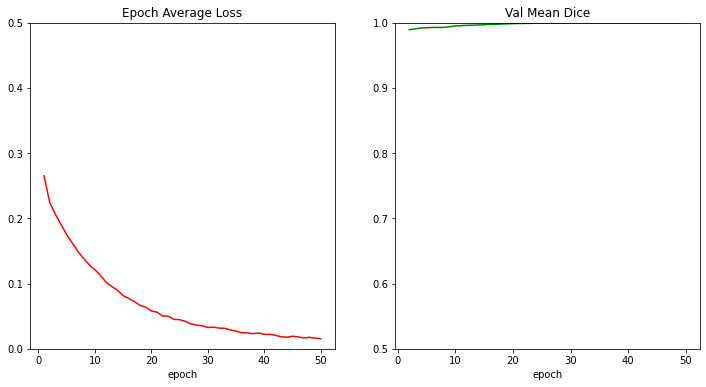

Dice in Test partition for run 80.9985248446464539
Training for run 9
----------
epoch 1/10
1/16, train_loss: 0.4234
2/16, train_loss: 0.4413
3/16, train_loss: 0.4555
4/16, train_loss: 0.4014
5/16, train_loss: 0.4088
6/16, train_loss: 0.4103
7/16, train_loss: 0.3976
8/16, train_loss: 0.4372
9/16, train_loss: 0.4005
10/16, train_loss: 0.4430
11/16, train_loss: 0.4046
12/16, train_loss: 0.3824
13/16, train_loss: 0.4138
14/16, train_loss: 0.4003
15/16, train_loss: 0.4131
16/16, train_loss: 0.4232
17/16, train_loss: 0.3428
epoch 1 average loss: 0.4117
----------
epoch 2/10
1/16, train_loss: 0.4013
2/16, train_loss: 0.3904
3/16, train_loss: 0.4014
4/16, train_loss: 0.3721
5/16, train_loss: 0.4211
6/16, train_loss: 0.3752
7/16, train_loss: 0.3774
8/16, train_loss: 0.4449
9/16, train_loss: 0.3835
10/16, train_loss: 0.4030
11/16, train_loss: 0.4062
12/16, train_loss: 0.3780
13/16, train_loss: 0.4145
14/16, train_loss: 0.3590
15/16, train_loss: 0.3841
16/16, train_loss: 0.3942
17/16, train_loss

saved new best metric model
current epoch: 16 current mean dice: 0.9986 best mean dice: 0.9986 at epoch 16
----------
epoch 17/10
1/16, train_loss: 0.1308
2/16, train_loss: 0.1466
3/16, train_loss: 0.1269
4/16, train_loss: 0.1262
5/16, train_loss: 0.1252
6/16, train_loss: 0.1329
7/16, train_loss: 0.1216
8/16, train_loss: 0.1218
9/16, train_loss: 0.1209
10/16, train_loss: 0.1197
11/16, train_loss: 0.1198
12/16, train_loss: 0.1326
13/16, train_loss: 0.1262
14/16, train_loss: 0.1160
15/16, train_loss: 0.1280
16/16, train_loss: 0.1229
17/16, train_loss: 0.1098
epoch 17 average loss: 0.1252
----------
epoch 18/10
1/16, train_loss: 0.1178
2/16, train_loss: 0.1205
3/16, train_loss: 0.1130
4/16, train_loss: 0.1206
5/16, train_loss: 0.1134
6/16, train_loss: 0.1219
7/16, train_loss: 0.1217
8/16, train_loss: 0.1228
9/16, train_loss: 0.1145
10/16, train_loss: 0.1144
11/16, train_loss: 0.1142
12/16, train_loss: 0.1173
13/16, train_loss: 0.1137
14/16, train_loss: 0.1131
15/16, train_loss: 0.1218
16/

saved new best metric model
current epoch: 32 current mean dice: 0.9997 best mean dice: 0.9997 at epoch 32
----------
epoch 33/10
1/16, train_loss: 0.0394
2/16, train_loss: 0.0503
3/16, train_loss: 0.0532
4/16, train_loss: 0.0354
5/16, train_loss: 0.0493
6/16, train_loss: 0.0413
7/16, train_loss: 0.0387
8/16, train_loss: 0.0616
9/16, train_loss: 0.0645
10/16, train_loss: 0.0392
11/16, train_loss: 0.0535
12/16, train_loss: 0.0409
13/16, train_loss: 0.0446
14/16, train_loss: 0.0364
15/16, train_loss: 0.0393
16/16, train_loss: 0.0354
17/16, train_loss: 0.0332
epoch 33 average loss: 0.0445
----------
epoch 34/10
1/16, train_loss: 0.0383
2/16, train_loss: 0.0377
3/16, train_loss: 0.0367
4/16, train_loss: 0.0466
5/16, train_loss: 0.0355
6/16, train_loss: 0.0480
7/16, train_loss: 0.0393
8/16, train_loss: 0.0382
9/16, train_loss: 0.0411
10/16, train_loss: 0.0405
11/16, train_loss: 0.0384
12/16, train_loss: 0.0451
13/16, train_loss: 0.0320
14/16, train_loss: 0.0348
15/16, train_loss: 0.0386
16/

saved new best metric model
current epoch: 48 current mean dice: 0.9998 best mean dice: 0.9999 at epoch 46
----------
epoch 49/10
1/16, train_loss: 0.0241
2/16, train_loss: 0.0178
3/16, train_loss: 0.0289
4/16, train_loss: 0.0192
5/16, train_loss: 0.0220
6/16, train_loss: 0.0335
7/16, train_loss: 0.0281
8/16, train_loss: 0.0178
9/16, train_loss: 0.0233
10/16, train_loss: 0.0171
11/16, train_loss: 0.0164
12/16, train_loss: 0.0212
13/16, train_loss: 0.0211
14/16, train_loss: 0.0200
15/16, train_loss: 0.0239
16/16, train_loss: 0.0195
17/16, train_loss: 0.0466
epoch 49 average loss: 0.0236
----------
epoch 50/10
1/16, train_loss: 0.0176
2/16, train_loss: 0.0151
3/16, train_loss: 0.0210
4/16, train_loss: 0.0176
5/16, train_loss: 0.0201
6/16, train_loss: 0.0146
7/16, train_loss: 0.0176
8/16, train_loss: 0.0235
9/16, train_loss: 0.0229
10/16, train_loss: 0.0170
11/16, train_loss: 0.0148
12/16, train_loss: 0.0195
13/16, train_loss: 0.0173
14/16, train_loss: 0.0200
15/16, train_loss: 0.0317
16/

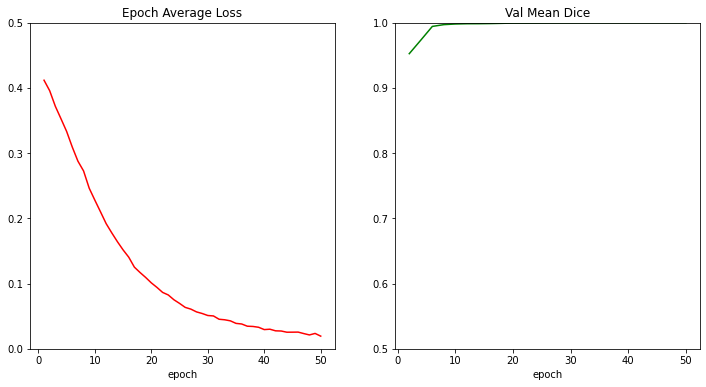

Dice in Test partition for run 90.9987583160400391


In [60]:
best_val_performances = []
test_performances = []
file_performances_test = open( OUTPUT+ 'performances_dice_'+EXPERIMENT.split('/')[0]+'.txt','w')
epocs = 50
runs = 10
for run_num in range(runs):
    print(f"Training for run {run_num}")
    model = monai.networks.nets.UNet(
        spatial_dims=2,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64, 128),
        strides=(2, 2, 2),
        num_res_units=2,
    ).to(device)

    loss_function = monai.losses.DiceLoss(sigmoid=True)
    optimizer     = torch.optim.Adam(model.parameters(), 1e-3)

    # start a typical PyTorch training
    val_interval = 2
    best_metric  = -1
    best_metric_epoch = -1
    
    epoch_loss_values  = list()
    metric_values      = list()
    metric_values_test = list()
    writer = SummaryWriter()
    
    for epoch in range(epocs):
        
        print("-" * 10)
        print(f"epoch {epoch + 1}/{10}")
        model.train()
        epoch_loss = 0
        step = 0
        
        for batch_data in train_loader:
            step += 1
            inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            epoch_len   = len(train_ds) // train_loader.batch_size
            
            print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
            writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
            
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
        if (epoch + 1) % val_interval == 0:
            model.eval()
            
            with torch.no_grad():
                val_images  = None
                val_labels  = None
                val_outputs = None
                
                for val_data in val_loader:
                    val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                    roi_size = (96, 96)
                    sw_batch_size = 4
                    val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                    val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                    # compute metric for current iteration
                    #print("========")
                    #print(val_outputs[0].shape,val_labels[0].shape)
                    dice_metric(y_pred=val_outputs, y=val_labels)
                    #print("========")

                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()
                metric_values.append(metric)
                
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    
                    torch.save(model.state_dict(),ROOT_EXP+"/models/"+EXPERIMENT+"run_" +str(run_num)+"_best_metric_model_segmentation2d_array.pth")
                   
                print("saved new best metric model")
                print(
                    "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                        epoch + 1, metric, best_metric, best_metric_epoch
                    )
                )
                writer.add_scalar("val_mean_dice", metric, epoch + 1)
                # plot the last model output as GIF image in TensorBoard with the corresponding image and label
                plot_2d_or_3d_image(val_images, epoch + 1, writer, index=0, tag="image")
                plot_2d_or_3d_image(val_labels, epoch + 1, writer, index=0, tag="label")
                plot_2d_or_3d_image(val_outputs, epoch + 1, writer, index=0, tag="output")
    
    best_val_performances.append(best_metric)
    
    
    plt.figure("train", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Epoch Average Loss")
    x = [i + 1 for i in range(len(epoch_loss_values))]
    y = epoch_loss_values
    plt.xlabel("epoch")
    plt.plot(x, y, color="red")
    plt.ylim([0.,0.5])
    plt.subplot(1, 2, 2)
    plt.title("Val Mean Dice")
    x = [val_interval * (i + 1) for i in range(len(metric_values))]
    y = metric_values
    plt.xlabel("epoch")
    plt.plot(x, y, color="green")
    plt.ylim([0.5,1])
    plt.savefig(OUTPUT+ f'trainin_dice_run_{run_num}_'+EXPERIMENT.split('/')[0]+'.jpg')
    plt.show()


    #Evaluation in the test partition
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        roi_size = (96, 96)
        sw_batch_size = 4
        test_outputs = sliding_window_inference(test_images, roi_size, sw_batch_size, model)
        test_outputs = [post_trans(i) for i in decollate_batch(test_outputs)]
        dice_metric_test(y_pred=test_outputs, y=test_labels)
    metric_test = dice_metric_test.aggregate().item()
    
    dice_metric_test.reset()
    test_performances.append(metric_test)
    print("Dice in Test partition for run " + str(run_num) + str(metric_test))
    file_performances_test.write(str(metric_test)+'\n')
    
    
    
file_performances_test.close()

In [61]:
test_performances

[0.9987756609916687,
 0.9990277290344238,
 0.998649001121521,
 0.9993247985839844,
 0.999156653881073,
 0.9985172152519226,
 0.9993299245834351,
 0.9985048174858093,
 0.9985248446464539,
 0.9987583160400391]

In [62]:
best_val_performances

[0.9998194575309753,
 0.9998797178268433,
 0.9998794794082642,
 0.9999086260795593,
 0.999864399433136,
 0.9997309446334839,
 0.9998943209648132,
 0.999849796295166,
 0.9997898936271667,
 0.999893844127655]